<a href="https://colab.research.google.com/github/PosgradoMNA/actividades-del-projecto-equipo-52/blob/main/Reto%20-%20Entrega%201_prueba3_avance_Superficiales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

> # **Reto - Entrega 1**
>### **Maestría en Inteligencia Artificial Aplicada**
>### **Curso: Inteligencia Artificial y Aprendizaje Automático**
>### **Tecnológico de Monterrey**
>### **Prof: María de la Paz Rico Fernández**

### **Genaro Ramos Higuera - A00351269**
### **Gerardo Aaron Castañeda Jaramillo - A01137646**

In [275]:
! pip install qeds fiona geopandas xgboost gensim folium pyLDAvis descartes

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [276]:
import pandas as pd
import numpy as np
from scipy import stats

from tqdm import tqdm

import matplotlib as mpl
import matplotlib.pyplot as plt 
import seaborn as sns 
import geopandas as gpd

import requests
import zipfile as zf
from io import BytesIO
import decimal

from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from shapely.geometry import Point

import qeds
qeds.themes.mpl_style();

from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin

from sklearn.preprocessing import LabelEncoder
from collections import Counter

In [277]:
def zip_to_df(url, filename, separator):

  print('Downloading started')
  # Split URL to get the file name
  req = requests.get(url)

  foldername = url.split('/')[-1].split('.')[-2]
  print('Downloading Completed') 

  # extracting the zip file contents
  zipfile= zf.ZipFile(BytesIO(req.content))
  zipfile.extractall('/content/sample_data/' + foldername)
  df = pd.read_csv("/content/sample_data/" + foldername + '/Datos_de_calidad_del_agua_2020/' + filename,sep=separator,encoding='latin-1')

  return df

## **Limpieza, análisis, visualización y agrupamiento.**

# **AGUAS SUBTERRANEAS**

In [278]:
url = 'http://201.116.60.46/Datos_de_calidad_del_agua_de_5000_sitios_de_monitoreo.zip'

df_asub = zip_to_df(url,'Datos_de_calidad_del_agua_de_sitios_de_monitoreo_de_aguas_subterraneas_2020.csv',',')
df_asub.head()

,CLAVE,SITIO,ORGANISMO_DE_CUENCA,ESTADO,MUNICIPIO,ACUIFERO,SUBTIPO,LONGITUD,LATITUD,PERIODO,...,CUMPLE_CON_DUR,CUMPLE_CON_CF,CUMPLE_CON_NO3,CUMPLE_CON_AS,CUMPLE_CON_CD,CUMPLE_CON_CR,CUMPLE_CON_HG,CUMPLE_CON_PB,CUMPLE_CON_MN,CUMPLE_CON_FE
0,DLAGU6,POZO SAN GIL,LERMA SANTIAGO PACIFICO,AGUASCALIENTES,ASIENTOS,VALLE DE CHICALOTE,POZO,-102.02210,22.20887,2020,...,SI,SI,SI,SI,SI,SI,SI,SI,SI,SI
1,DLAGU6516,POZO R013 CAÑADA HONDA,LERMA SANTIAGO PACIFICO,AGUASCALIENTES,AGUASCALIENTES,VALLE DE CHICALOTE,POZO,-102.20075,21.99958,2020,...,SI,SI,SI,SI,SI,SI,SI,SI,SI,SI
2,DLAGU7,POZO COSIO,LERMA SANTIAGO PACIFICO,AGUASCALIENTES,COSIO,VALLE DE AGUASCALIENTES,POZO,-102.28801,22.36685,2020,...,SI,SI,SI,NO,SI,SI,SI,SI,SI,SI
3,DLAGU9,POZO EL SALITRILLO,LERMA SANTIAGO PACIFICO,AGUASCALIENTES,RINCON DE ROMOS,VALLE DE AGUASCALIENTES,POZO,-102.29449,22.18435,2020,...,SI,SI,SI,SI,SI,SI,SI,SI,SI,SI
4,DLBAJ107,RANCHO EL TECOLOTE,PENINSULA DE BAJA CALIFORNIA,BAJA CALIFORNIA SUR,LA PAZ,TODOS SANTOS,POZO,-110.24480,23.45138,2020,...,SI,SI,NO,SI,SI,SI,SI,SI,SI,SI


In [279]:
asub = df_asub.copy()
asub.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1068 entries, 0 to 1067
Data columns (total 57 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   CLAVE                 1068 non-null   object 
 1   SITIO                 1068 non-null   object 
 2   ORGANISMO_DE_CUENCA   1068 non-null   object 
 3   ESTADO                1068 non-null   object 
 4   MUNICIPIO             1068 non-null   object 
 5   ACUIFERO              1068 non-null   object 
 6   SUBTIPO               1068 non-null   object 
 7   LONGITUD              1068 non-null   float64
 8   LATITUD               1068 non-null   float64
 9   PERIODO               1068 non-null   int64  
 10  ALC_mg/L              1064 non-null   float64
 11  CALIDAD_ALC           1064 non-null   object 
 12  CONDUCT_mS/cm         1062 non-null   float64
 13  CALIDAD_CONDUC        1062 non-null   object 
 14  SDT_mg/L              0 non-null      float64
 15  SDT_M_mg/L           

Donde:
* 0 - CLAVE: es como un ID
* 1 - SITIO: es categórica sobre ubicación
* 2 - ORGANISMO_DE_CUENCA: categórica que identifica al responsable de administrar y preservar las aguas nacionales en cada una de las trece regiones hidrológico-administrativas en que se ha dividido el país
* 3 - ESTADO: categórica sobre el estado en que está ubicado
* 4 - MUNICIPIO: categórica sobre el municipio en que está ubicado
* 5 - ACUIFERO: categórica sobre el acuífero al que pertenece
* 6 - SUBTIPO: categórica sobre el tipo de yacimiento al que pertenece
* 7 - LONGITUD: numérica y parte de coordenada geográfica
* 8 - LATITUD: numérica y parte de coordenada geográfica
* 9 - PERIODO: periodo de recolección de datos (todos son 2020)
* 10 - ALC_mg/L: numérica de calidad del agua para alcalinidad
* 11 - CALIDAD_ALC: categórica de calidad del agua para alcalinidad
* 12 - CONDUCT_mS/cm: numérica de calidad del agua para conductividad
* 13 - CALIDAD_CONDUC: categórica de calidad del agua para conductividad
* 14 - SDT_mg/L: numérica de calidad del agua para SOLIDOS DISUELTOS TOTALES (numérica vacía)
* 15 - SDT_M_mg/L: numérica de calidad del agua para solidos disueltos totales
* 16 - CALIDAD_SDT_ra: categórica de calidad del agua para solidos disueltos totales - riego agrícola
* 17 - CALIDAD_SDT_salin: categórica de calidad del agua para solidos disueltos totales - SALINIZACION
* 18 - FLUORUROS_mg/L: numérica de calidad del agua para FLUORUROS
* 19 - CALIDAD_FLUO: categórica de calidad del agua para FLUORUROS
* 20 - DUR_mg/L: numérica de calidad del agua para DUREZA
* 21 - CALIDAD_DUR: categórica de calidad del agua para DUREZA
* 22 - COLI_FEC_NMP/100_mL: numérica de calidad del agua para COLIFORMES FECALES
* 23 - CALIDAD_COLI_FEC: categórica de calidad del agua para COLIFORMES FECALES
* 24 - N_NO3_mg/L: numérica de calidad del agua para NITROGENO DE NITRATOS 
* 25 - CALIDAD_N_NO3: categórica de calidad del agua para NITROGENO DE NITRATOS 
* 26 - AS_TOT_mg/L: numérica de calidad del agua para ARSENICO
* 27 - CALIDAD_AS: categórica de calidad del agua para ARSENICO
* 28 - CD_TOT_mg/L: numérica de calidad del agua para CADMIO
* 29 - CALIDAD_CD: categórica de calidad del agua para CADMIO
* 30 - CR_TOT_mg/L: numérica de calidad del agua para CROMO
* 31 - CALIDAD_CR: categórica de calidad del agua para CROMO
* 32 - HG_TOT_mg/L: numérica de calidad del agua para MERCURIO
* 33 - CALIDAD_HG: categórica de calidad del agua para MERCURIO
* 34 - PB_TOT_mg/L: numérica de calidad del agua para PLOMO
* 35 - CALIDAD_PB: categórica de calidad del agua para PLOMO
* 36 - MN_TOT_mg/L: numérica de calidad del agua para MANGANESO
* 37 - CALIDAD_MN: categórica de calidad del agua para MANGANESO
* 38 - FE_TOT_mg/L: numérica de calidad del agua para MANGANESO
* 39 - CALIDAD_FE: categórica de calidad del agua para MANGANESO
* 40 - SEMAFORO: categórica sobre si el agua es potable o no
* 41 - CONTAMINANTES: string de que contaminantes tiene, dependiente de las variables 10-39
* 42 - CUMPLE_CON_ALC: binaria sobre si cumple criterio de CALIDAD_ALC
* 43 - CUMPLE_CON_COND: binaria sobre si cumple criterio de CALIDAD_COND
* 44 - CUMPLE_CON_SDT_ra: binaria sobre si cumple criterio de CALIDAD_STD_ra
* 45 - CUMPLE_CON_SDT_salin: binaria sobre si cumple criterio de CALIDAD_STD_salin
* 46 - CUMPLE_CON_FLUO: binaria sobre si cumple criterio de CALIDAD_FLUO
* 47 - CUMPLE_CON_DUR: binaria sobre si cumple criterio de CALIDAD_DUR
* 48 - CUMPLE_CON_CF: binaria sobre si cumple criterio de CALIDAD_CF
* 49 - CUMPLE_CON_NO3: binaria sobre si cumple criterio de CALIDAD_NO3
* 50 - CUMPLE_CON_AS: binaria sobre si cumple criterio de CALIDAD_AS
* 51 - CUMPLE_CON_CD: binaria sobre si cumple criterio de CALIDAD_CD
* 52 - CUMPLE_CON_CR: binaria sobre si cumple criterio de CALIDAD_CR
* 53 - CUMPLE_CON_HG: binaria sobre si cumple criterio de CALIDAD_HG
* 54 - CUMPLE_CON_PB: binaria sobre si cumple criterio de CALIDAD_PB
* 55 - CUMPLE_CON_MN: binaria sobre si cumple criterio de CALIDAD_MN
* 56 - CUMPLE_CON_FE: binaria sobre si cumple criterio de CALIDAD_FE




## **Limpieza de base de datos:**

De entrada observamos que 'SDT_mg/L ' no tiene valores, así que eliminamos la columna del dataframe:

In [280]:
asub.drop('SDT_mg/L', inplace=True, axis=1)

De igual manera observamos que existen dos valores de calidad para solidos disueltos totales, siendo una de ellas para uso agrícola. Y solo nos interesa la de salinización, ya que es la que nos determina si es potable o no. Así que la eliminamos lo referente a ella:

In [281]:
asub.drop('CALIDAD_SDT_ra', inplace=True, axis=1)
asub.drop('CUMPLE_CON_SDT_ra', inplace=True, axis=1)

Otra variable a visualizar es la de periodo:

In [282]:
asub['PERIODO'].value_counts()

2020    1068
Name: PERIODO, dtype: int64

Donde observamos que todos los valores son 2020. Dado que todos los valores son iguales, la eliminamos:

In [283]:
asub.drop('PERIODO', inplace=True, axis=1)

Finalmente, la variable de contaminantes solo es un string donde indica que contaminantes no pasaron el criterio sobre si es agua de buena calidad o no. Así que la podemos eliminar:

In [284]:
asub.drop('CONTAMINANTES', inplace=True, axis=1)

Remplazamos algunos valores de nombres de columnas para que todas tengan el mismo formato:

In [285]:
asub.rename(columns = {'COLI_FEC_NMP/100_mL':'CF_NMP/100_mL','CALIDAD_COLI_FEC':'CALIDAD_CF',
                       'N_NO3_mg/L':'NNO3_mg/L','CALIDAD_N_NO3':'CALIDAD_NNO3','CUMPLE_CON_NO3':'CUMPLE_CON_NNO3',
                       'FLUORUROS_mg/L':'FLUO_mg/L',
                       'CONDUCT_mS/cm':'COND_mS/cm','CALIDAD_CONDUC':'CALIDAD_COND',
                       'CALIDAD_SDT_salin':'CALIDAD_SDT','CUMPLE_CON_SDT_salin':'CUMPLE_CON_SDT'
                       }, inplace = True)

Separamos variables por sus tipos:

In [286]:
#definimos variables numéricas #16
num_nom = ['LONGITUD','LATITUD','ALC_mg/L','COND_mS/cm','SDT_M_mg/L','FLUO_mg/L','DUR_mg/L','CF_NMP/100_mL','NNO3_mg/L','AS_TOT_mg/L',
           'CD_TOT_mg/L','CR_TOT_mg/L','HG_TOT_mg/L','PB_TOT_mg/L','MN_TOT_mg/L','FE_TOT_mg/L']
#definimos variables categóricas #22
cat_nom = ['SITIO','ORGANISMO_DE_CUENCA','ESTADO','MUNICIPIO','ACUIFERO','SUBTIPO','CALIDAD_COND','CALIDAD_ALC','CALIDAD_SDT','CALIDAD_FLUO','CALIDAD_DUR',
           'CALIDAD_CF','CALIDAD_NNO3','CALIDAD_AS','CALIDAD_CD','CALIDAD_CR','CALIDAD_HG','CALIDAD_PB','CALIDAD_MN','CALIDAD_FE']
#definimos variables binarias #14
bin_nom = ['CUMPLE_CON_ALC','CUMPLE_CON_COND','CUMPLE_CON_SDT','CUMPLE_CON_FLUO','CUMPLE_CON_DUR','CUMPLE_CON_CF','CUMPLE_CON_NNO3','CUMPLE_CON_AS','CUMPLE_CON_CD',
           'CUMPLE_CON_CR','CUMPLE_CON_HG','CUMPLE_CON_PB','CUMPLE_CON_MN','CUMPLE_CON_FE']
#VARIABLE CATEGORICA DE SALIDA Y  #1
y_nom = ['SEMAFORO']

Y comenzamos a explorar para limpiar:

### Variables numéricas:

In [287]:
asub[num_nom].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1068 entries, 0 to 1067
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   LONGITUD       1068 non-null   float64
 1   LATITUD        1068 non-null   float64
 2   ALC_mg/L       1064 non-null   float64
 3   COND_mS/cm     1062 non-null   float64
 4   SDT_M_mg/L     1066 non-null   object 
 5   FLUO_mg/L      1068 non-null   object 
 6   DUR_mg/L       1067 non-null   object 
 7   CF_NMP/100_mL  1068 non-null   object 
 8   NNO3_mg/L      1067 non-null   object 
 9   AS_TOT_mg/L    1068 non-null   object 
 10  CD_TOT_mg/L    1068 non-null   object 
 11  CR_TOT_mg/L    1068 non-null   object 
 12  HG_TOT_mg/L    1068 non-null   object 
 13  PB_TOT_mg/L    1068 non-null   object 
 14  MN_TOT_mg/L    1068 non-null   object 
 15  FE_TOT_mg/L    1068 non-null   object 
dtypes: float64(4), object(12)
memory usage: 133.6+ KB


Observamos que no todas nos arrojan como Dtype float, lo cual nos impide utilizar el método de describe(), así que las comenzamos a analizar una por una para determinar que sucede:

Longitud y latitud no contienen valores nulos y ya están en float64, así que se quedan igual. Sin embargo, observamos que, para las demás variables, algunas si tienen valores nulos. Estas variables están relacionadas con su respectiva variable categórica de calidad, así como su variable binaria sobre si cumple o no con el criterio de calidad. Igualmente, si alguna variable binaria no cumple, la variable de CONTAMINANTES lo refleja. Por lo que observaremos sus valores faltantes junto con sus variables relacionadas.

In [288]:
temp_num_nom = num_nom.copy()
temp_num_nom.remove('LONGITUD')
temp_num_nom.remove('LATITUD')

for col in temp_num_nom:
  new_cols = list()
  if asub[col].isna().sum() > 0:
    contaminant = col.split('_', 1)[0]
    new_cols.append(col)
    new_cols.append('CALIDAD_'+contaminant)
    new_cols.append('CUMPLE_CON_'+contaminant)
    new_cols.append('SEMAFORO')
    indx_na = asub[asub[col].isnull()].index.tolist()
    temp_df = pd.DataFrame(columns=new_cols)
    if len(indx_na) > 0:
      for indx in indx_na:
        temp_df = temp_df.append(asub[new_cols].iloc[indx], ignore_index = True)
      print(str(len(indx_na)),'NA values in numeric variable:',col)
      display(temp_df)

4 NA values in numeric variable: ALC_mg/L


,ALC_mg/L,CALIDAD_ALC,CUMPLE_CON_ALC,SEMAFORO
0,NaN,NaN,ND,Rojo
1,NaN,NaN,ND,Verde
2,NaN,NaN,ND,Verde
3,NaN,NaN,ND,Rojo


6 NA values in numeric variable: COND_mS/cm


,COND_mS/cm,CALIDAD_COND,CUMPLE_CON_COND,SEMAFORO
0,NaN,NaN,ND,Rojo
1,NaN,NaN,ND,Verde
2,NaN,NaN,ND,Rojo
3,NaN,NaN,ND,Amarillo
4,NaN,NaN,ND,Verde
5,NaN,NaN,ND,Verde


2 NA values in numeric variable: SDT_M_mg/L


,SDT_M_mg/L,CALIDAD_SDT,CUMPLE_CON_SDT,SEMAFORO
0,NaN,NaN,ND,Rojo
1,NaN,NaN,ND,Amarillo


1 NA values in numeric variable: DUR_mg/L


,DUR_mg/L,CALIDAD_DUR,CUMPLE_CON_DUR,SEMAFORO
0,NaN,NaN,ND,Verde


1 NA values in numeric variable: NNO3_mg/L


,NNO3_mg/L,CALIDAD_NNO3,CUMPLE_CON_NNO3,SEMAFORO
0,NaN,NaN,ND,Verde


Donde encontramos 5 tipos de contaminantes que contienen datos nulos. Y efectivamente, comprobamos que, si falta un dato en la cantidad del contaminante, también falta en su variable de calidad, y no tiene efecto alguno en la variable de salida.

Contamos cuantas filas con valores nulos existen en los valores numéricos:

In [289]:
nasum = sum([True for idx,row in asub[num_nom].iterrows() if any(row.isnull())])
nasum

14

Evaluamos el porcentaje de filas con valores nulos contra el total:

In [290]:
str((nasum/len(asub.index))*100)+'%'

'1.3108614232209739%'

Dado que es un porcentaje muy bajo, eliminamos las filas con valores nulos. Es preferible que imputarle valores, dado que de las variables numéricas se definen algunas categóricas, y de las categorías las binarias. E imputar por la media o la mediana podría estar cambiando el resultado del semáforo.

In [291]:
row_na = list()
for idx,row in asub[num_nom].iterrows():
  if any(row.isnull()):
    row_na.append(idx)
asub.drop(row_na, inplace=True)
asub.reset_index(drop=True,inplace=True)

Ahora observemos el por qué algunas variables numéricas las arroja como tipo object:

In [292]:
asub[num_nom]

,LONGITUD,LATITUD,ALC_mg/L,COND_mS/cm,SDT_M_mg/L,FLUO_mg/L,DUR_mg/L,CF_NMP/100_mL,NNO3_mg/L,AS_TOT_mg/L,CD_TOT_mg/L,CR_TOT_mg/L,HG_TOT_mg/L,PB_TOT_mg/L,MN_TOT_mg/L,FE_TOT_mg/L
0,-102.02210,22.20887,229.990,940.0,603.6,0.9766,213.732,<1.1,4.184656,0.0161,<0.003,<0.005,<0.0005,<0.005,<0.0015,0.0891
1,-102.20075,21.99958,231.990,608.0,445.4,0.9298,185.0514,<1.1,5.75011,0.0134,<0.003,<0.005,<0.0005,<0.005,<0.0015,<0.025
2,-102.28801,22.36685,204.920,532.0,342,1.8045,120.719,<1.1,1.449803,0.037,<0.003,<0.005,<0.0005,<0.005,<0.0015,<0.025
3,-102.29449,22.18435,327.000,686.0,478.6,1.1229,199.879,<1.1,1.258597,0.0154,<0.003,0.005,<0.0005,<0.005,<0.0015,<0.025
4,-110.24480,23.45138,309.885,1841.0,1179,0.2343,476.9872,291,15.672251,<0.01,<0.003,<0.005,<0.0005,<0.005,<0.0015,<0.025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1049,-99.54191,24.76036,231.045,2350.0,1545.8,<0.2,752.096,<1.1,14.615488,<0.01,<0.003,<0.005,<0.0005,<0.005,<0.0015,<0.025
1050,-99.70099,24.78280,256.000,529.0,297,<0.2,273,<1.1,77.392,<0.01,<0.003,<0.005,<0.0005,<0.005,0.00709,0.07578
1051,-99.82249,25.55197,330.690,2600.0,1873,0.7574,660.2126,620,36.477104,<0.01,<0.003,<0.005,<0.0005,<0.005,0.0242,0.2129
1052,-100.32683,24.80118,193.140,873.0,690.6667,0.7108,406.368,<1.1,<0.02,<0.01,<0.003,<0.005,<0.0005,<0.005,0.012,0.1786


Observamos que algunos valores son de tipo string, ya que tienen el carácter '<' al inicio. Lo que podemos hacer es sustituirlos por un valor tipo float, que sea menor a lo que se indica:

In [293]:
for col in asub[num_nom].columns:
  i = 0
  for i in range(0,len(asub[col].index)):
    val = ''
    if '<' in str(asub[col][i]):
      val = asub[col][i].replace('<', '')
      dec = abs(decimal.Decimal(val).as_tuple().exponent) + 1
      val = float(val) - 1/np.power(10,dec)
      asub[col].replace(asub[col][i],val,inplace=True)

for col in asub[num_nom].columns:
  asub[col] = pd.to_numeric(asub[col])

Y observamos los nuevos valores donde ahora todas las columnas numéricas son float y no existen valores nulos:

In [294]:
asub[num_nom].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1054 entries, 0 to 1053
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   LONGITUD       1054 non-null   float64
 1   LATITUD        1054 non-null   float64
 2   ALC_mg/L       1054 non-null   float64
 3   COND_mS/cm     1054 non-null   float64
 4   SDT_M_mg/L     1054 non-null   float64
 5   FLUO_mg/L      1054 non-null   float64
 6   DUR_mg/L       1054 non-null   float64
 7   CF_NMP/100_mL  1054 non-null   float64
 8   NNO3_mg/L      1054 non-null   float64
 9   AS_TOT_mg/L    1054 non-null   float64
 10  CD_TOT_mg/L    1054 non-null   float64
 11  CR_TOT_mg/L    1054 non-null   float64
 12  HG_TOT_mg/L    1054 non-null   float64
 13  PB_TOT_mg/L    1054 non-null   float64
 14  MN_TOT_mg/L    1054 non-null   float64
 15  FE_TOT_mg/L    1054 non-null   float64
dtypes: float64(16)
memory usage: 131.9 KB


Y observamos las variables numéricas donde ni una tiene ya el símbolo de '<':

In [295]:
asub[num_nom]

,LONGITUD,LATITUD,ALC_mg/L,COND_mS/cm,SDT_M_mg/L,FLUO_mg/L,DUR_mg/L,CF_NMP/100_mL,NNO3_mg/L,AS_TOT_mg/L,CD_TOT_mg/L,CR_TOT_mg/L,HG_TOT_mg/L,PB_TOT_mg/L,MN_TOT_mg/L,FE_TOT_mg/L
0,-102.02210,22.20887,229.990,940.0,603.6000,0.9766,213.7320,1.09,4.184656,0.0161,0.0029,0.0049,0.00049,0.0049,0.00149,0.08910
1,-102.20075,21.99958,231.990,608.0,445.4000,0.9298,185.0514,1.09,5.750110,0.0134,0.0029,0.0049,0.00049,0.0049,0.00149,0.02490
2,-102.28801,22.36685,204.920,532.0,342.0000,1.8045,120.7190,1.09,1.449803,0.0370,0.0029,0.0049,0.00049,0.0049,0.00149,0.02490
3,-102.29449,22.18435,327.000,686.0,478.6000,1.1229,199.8790,1.09,1.258597,0.0154,0.0029,0.0050,0.00049,0.0049,0.00149,0.02490
4,-110.24480,23.45138,309.885,1841.0,1179.0000,0.2343,476.9872,291.00,15.672251,0.0090,0.0029,0.0049,0.00049,0.0049,0.00149,0.02490
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1049,-99.54191,24.76036,231.045,2350.0,1545.8000,0.1900,752.0960,1.09,14.615488,0.0090,0.0029,0.0049,0.00049,0.0049,0.00149,0.02490
1050,-99.70099,24.78280,256.000,529.0,297.0000,0.1900,273.0000,1.09,77.392000,0.0090,0.0029,0.0049,0.00049,0.0049,0.00709,0.07578
1051,-99.82249,25.55197,330.690,2600.0,1873.0000,0.7574,660.2126,620.00,36.477104,0.0090,0.0029,0.0049,0.00049,0.0049,0.02420,0.21290
1052,-100.32683,24.80118,193.140,873.0,690.6667,0.7108,406.3680,1.09,0.019000,0.0090,0.0029,0.0049,0.00049,0.0049,0.01200,0.17860


### Variables categóricas:

Una exploración rápida de las variables categóricas:

In [296]:
for col in asub[cat_nom].columns:
  print(asub[col].value_counts(),'\n')

POZO VILLA UNION                    2
EL FUERTE                           2
FINCA SANTA CRUZ                    1
EST. JUAREZ                         1
SANTA TERESA 2A. SECCION            1
                                   ..
POZO SAN FRANCISCO BOJAY COLONIA    1
POZO SANTA ANA AHUEHUEPAN           1
POZO SANTA MARIA DAXTHO             1
POZO PEDRO MARIA ANAYA              1
COMUNIDAD LA REFORMA                1
Name: SITIO, Length: 1052, dtype: int64 

CUENCAS CENTRALES DEL NORTE     231
LERMA SANTIAGO PACIFICO         166
PENINSULA DE YUCATAN            125
NOROESTE                         93
PENINSULA DE BAJA CALIFORNIA     86
BALSAS                           68
RIO BRAVO                        65
PACIFICO NORTE                   60
GOLFO NORTE                      53
AGUAS DEL VALLE DE MEXICO        37
FRONTERA SUR                     34
GOLFO CENTRO                     20
PACIFICO SUR                     16
Name: ORGANISMO_DE_CUENCA, dtype: int64 

DURANGO                       

A primera vista podemos observar que 'SITIO','ESTADO','MUNICIPIO', y 'ACUIFERO' tienen demasiados valores como para que nos sean útiles para el análisis. No los movemos. Sin embargo, sabemos que todos están relacionados con la posición geográfica, por lo que posiblemente nos termine ayudando longitud y latitud.

Seguido, 'ORGANISMO_DE_CUENCA' solo tiene 12 categorías diferentes, que aunque también dependen de su posición geográfica, podría ser útil para el análisis ya que es el organismo responsable de las aguas subterráneas.

Tercero, tenemos 8 categorías para 'SUBTIPO', lo cual también es una variable que posiblemente nos será útil para el análisis.

Y finalmente, tenemos las categorías que representan la calidad de cada tipo de contaminante. Estas se encuentran en cada una con un tipo diferente de string para cada clase. Se decidió usar replace en vez de label encoding para asegurar el orden de cada categoría con su nuevo número asignado. Empezando por un 1 el de mejor calidad, a N, siendo N el valor que represente la mayor contaminación.

In [297]:
cal_nom = ['CALIDAD_COND','CALIDAD_ALC','CALIDAD_SDT','CALIDAD_FLUO','CALIDAD_DUR', 'CALIDAD_CF','CALIDAD_NNO3','CALIDAD_AS',
           'CALIDAD_CD','CALIDAD_CR','CALIDAD_HG','CALIDAD_PB','CALIDAD_MN','CALIDAD_FE']

asub['CALIDAD_COND'].replace({'Excelente para riego':1,'Buena para riego':2,'Permisible para riego':3,'Dudosa para riego':4,'Indeseable para riego':5},inplace=True)

asub['CALIDAD_ALC'].replace({'Baja':1,'Media':2,'Alta':3,'Indeseable como FAAP':4,'Indeseable':5},inplace=True)

asub['CALIDAD_SDT'].replace({'Potable - Dulce':1,'Ligeramente salobres':2,'Salobres':3,'Salinas':4},inplace=True)

asub['CALIDAD_FLUO'].replace({'Potable - Optima':1,'Media':2,'Baja':3,'Alta':4},inplace=True)

asub['CALIDAD_DUR'].replace({'Potable - Suave':1,'Potable - Moderadamente suave':2,'Potable - Dura':3,'Muy dura e indeseable usos industrial y domestico':4},inplace=True)

asub['CALIDAD_CF'].replace({'Potable - Excelente':1,'Buena calidad':2,'Aceptable':3,'Contaminada':4,'Fuertemente contaminada':5},inplace=True)

asub['CALIDAD_NNO3'].replace({'Potable - Excelente':1,'Potable - Buena calidad':2,'No apta como FAAP':3},inplace=True)

asub['CALIDAD_AS'].replace({'Potable - Excelente':1,'Apta como FAAP':2,'No apta como FAAP':3},inplace=True)

asub['CALIDAD_CD'].replace({'Potable - Excelente':1,'No apta como FAAP':2},inplace=True)
asub['CALIDAD_CR'].replace({'Potable - Excelente':1,'No apta como FAAP':2},inplace=True)
asub['CALIDAD_HG'].replace({'Potable - Excelente':1,'No apta como FAAP':2},inplace=True)
asub['CALIDAD_PB'].replace({'Potable - Excelente':1,'No apta como FAAP':2},inplace=True)

asub['CALIDAD_MN'].replace({'Potable - Excelente':1,'Sin efectos en la salud - Puede dar color al agua':2,'Puede afectar la salud':3},inplace=True)

asub['CALIDAD_FE'].replace({'Potable - Excelente':1,'Sin efectos en la salud - Puede dar color al agua':2},inplace=True)

Repetimos el conteo para verificar:

In [298]:
for col in asub[cal_nom].columns:
  print(asub[col].value_counts(),'\n')

3    458
2    429
4     72
5     51
1     44
Name: CALIDAD_COND, dtype: int64 

3    790
2    184
4     57
1     23
Name: CALIDAD_ALC, dtype: int64 

1    826
2    158
3     67
4      3
Name: CALIDAD_SDT, dtype: int64 

3    426
1    225
2    213
4    190
Name: CALIDAD_FLUO, dtype: int64 

3    572
4    225
2    165
1     92
Name: CALIDAD_DUR, dtype: int64 

1    730
2    204
3     59
4     49
5     12
Name: CALIDAD_CF, dtype: int64 

1    780
2    194
3     80
Name: CALIDAD_NNO3, dtype: int64 

1    805
3    125
2    124
Name: CALIDAD_AS, dtype: int64 

1    1052
2       2
Name: CALIDAD_CD, dtype: int64 

1    1039
2      15
Name: CALIDAD_CR, dtype: int64 

1    1053
2       1
Name: CALIDAD_HG, dtype: int64 

1    1042
2      12
Name: CALIDAD_PB, dtype: int64 

1    969
3     50
2     35
Name: CALIDAD_MN, dtype: int64 

1    920
2    134
Name: CALIDAD_FE, dtype: int64 



Y finalmente, convertimos 'ORGANISMO_DE_CUENCA' y 'SUBTIPO' a categorías con números:

In [299]:
enc1 = OrdinalEncoder()
enc1.fit(asub[['ORGANISMO_DE_CUENCA']])

asub[['ORGANISMO_DE_CUENCA']] = enc1.transform(asub[['ORGANISMO_DE_CUENCA']])

asub['ORGANISMO_DE_CUENCA'].value_counts()

2.0     231
6.0     166
11.0    125
7.0      93
10.0     86
1.0      68
12.0     65
8.0      60
5.0      53
0.0      37
3.0      34
4.0      20
9.0      16
Name: ORGANISMO_DE_CUENCA, dtype: int64

In [300]:
enc2 = OrdinalEncoder()
enc2.fit(asub[['SUBTIPO']])

asub[['SUBTIPO']] = enc2.transform(asub[['SUBTIPO']])

asub['SUBTIPO'].value_counts()

5.0    1025
3.0      12
1.0       7
6.0       4
4.0       3
2.0       1
7.0       1
0.0       1
Name: SUBTIPO, dtype: int64

Por ultimo, hacemos el cambio del dato de SEMAFORO de Object a valores de etiquetas para el Verde, Amarillo y Rojo a valores 1, 2, y 3:

In [301]:
asub['SEMAFORO'].replace({'Verde':1,'Amarillo':2,'Rojo':3},inplace=True)

### Y finalmente nos quedamos con las siguientes divisiones de variables:

In [302]:
#definimos variables numéricas #16
num_nom_geo = ['LONGITUD','LATITUD']
num_nom_cal = ['ALC_mg/L','COND_mS/cm','SDT_M_mg/L','FLUO_mg/L','DUR_mg/L','CF_NMP/100_mL','NNO3_mg/L','AS_TOT_mg/L', 'CD_TOT_mg/L','CR_TOT_mg/L',
               'HG_TOT_mg/L','PB_TOT_mg/L','MN_TOT_mg/L','FE_TOT_mg/L']
#definimos variables categóricas #16
cat_nom = ['ORGANISMO_DE_CUENCA','SUBTIPO']
cat_nom_cal = ['CALIDAD_COND','CALIDAD_ALC','CALIDAD_SDT','CALIDAD_FLUO','CALIDAD_DUR', 'CALIDAD_CF','CALIDAD_NNO3','CALIDAD_AS',
               'CALIDAD_CD','CALIDAD_CR','CALIDAD_HG','CALIDAD_PB','CALIDAD_MN','CALIDAD_FE']
#definimos variables binarias #14
bin_nom = ['CUMPLE_CON_ALC','CUMPLE_CON_COND','CUMPLE_CON_SDT','CUMPLE_CON_FLUO','CUMPLE_CON_DUR','CUMPLE_CON_CF','CUMPLE_CON_NNO3','CUMPLE_CON_AS','CUMPLE_CON_CD',
           'CUMPLE_CON_CR','CUMPLE_CON_HG','CUMPLE_CON_PB','CUMPLE_CON_MN','CUMPLE_CON_FE']
#VARIABLE CATEGORICA DE SALIDA Y  #1
y_nom = ['SEMAFORO']

## **Explorar  cada datos (auxiliate de describe(), mean(), plot, boxplot de pandas):**

### Comenzamos con algunos gráficos de **histogramas** de las variables numéricas para entender sus distribuciones:


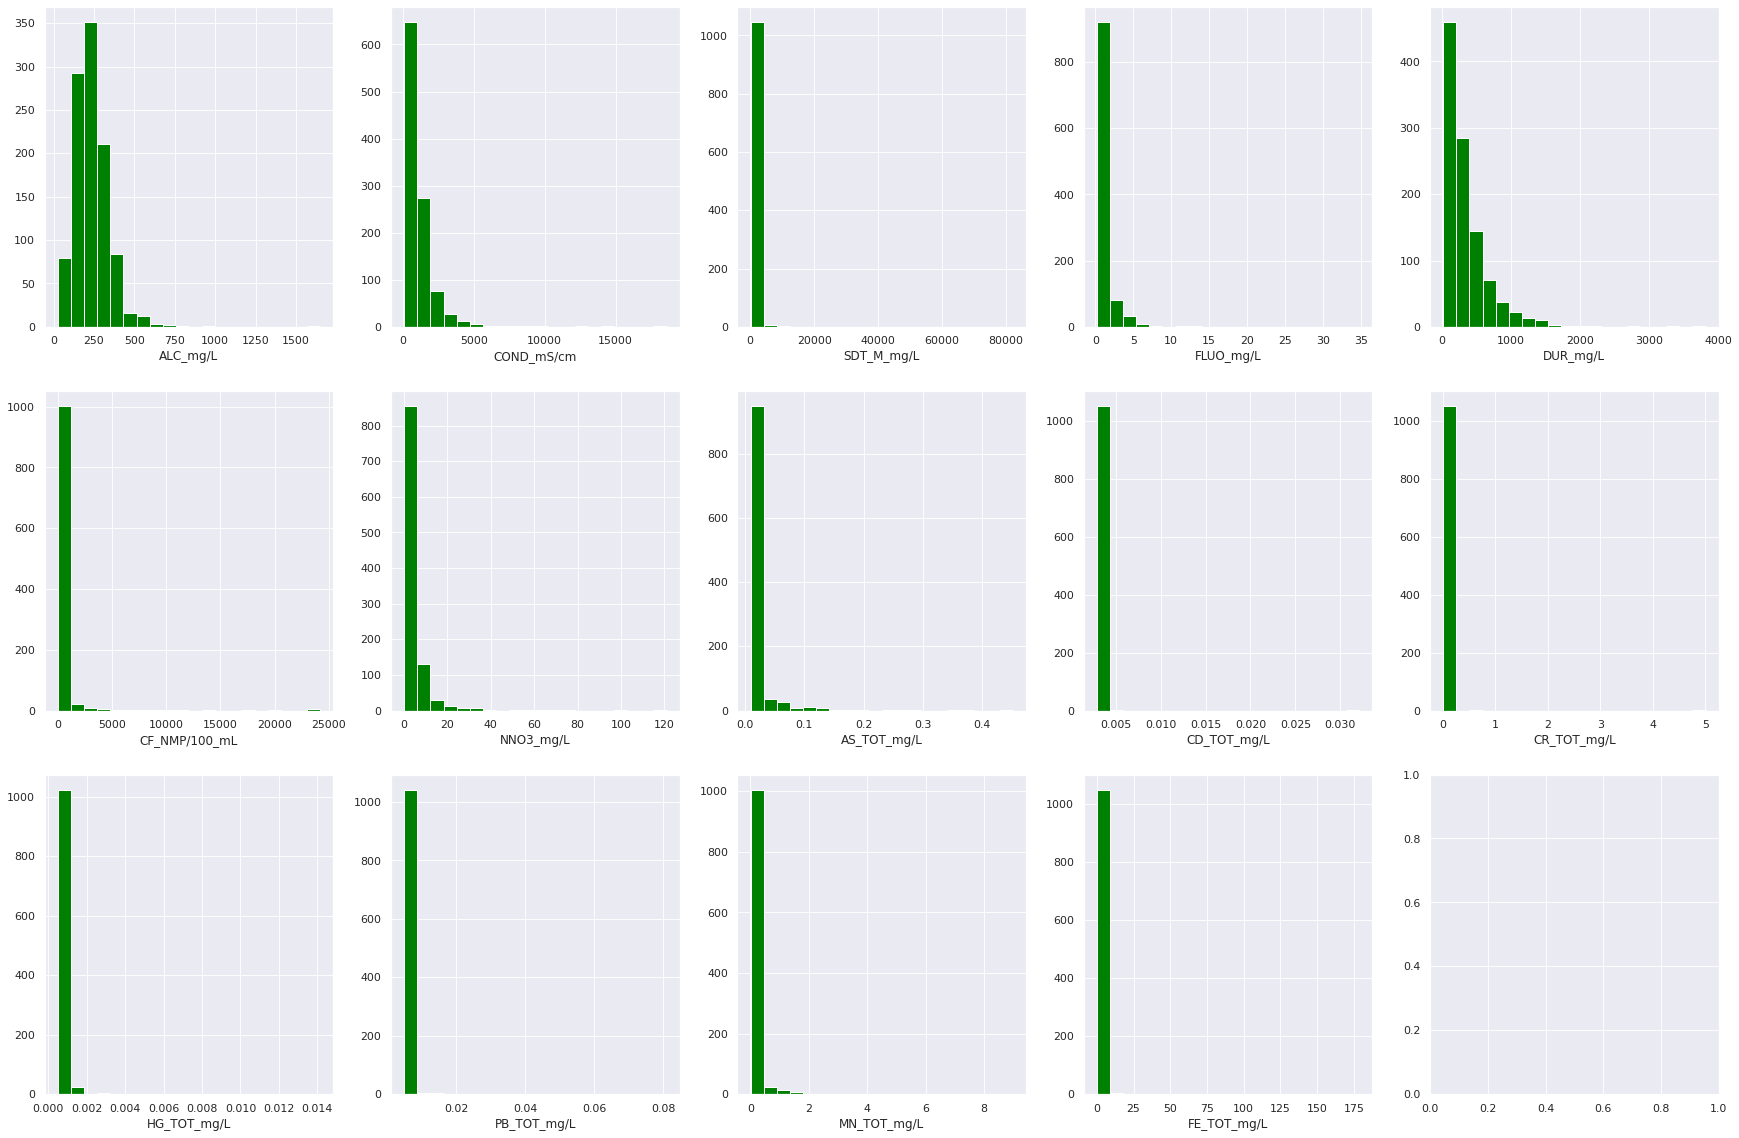

In [303]:
sns.set(rc={'figure.figsize':(30,20)})
fig, axes = plt.subplots(3, 5)
i = 0
for col in asub[num_nom_cal].columns:
  plt.subplot(3, 5,i+1) 
  plt.hist(asub[col], bins=20,color='green') 
  plt.xlabel(asub[num_nom_cal].columns[i])
  i = i + 1

Vemos que en los gráficos se muestra que las variables numéricas tienen en su mayoría un sesgo positivo.

### Ahora veamos las gráficas de **Boxplot** de cada una:

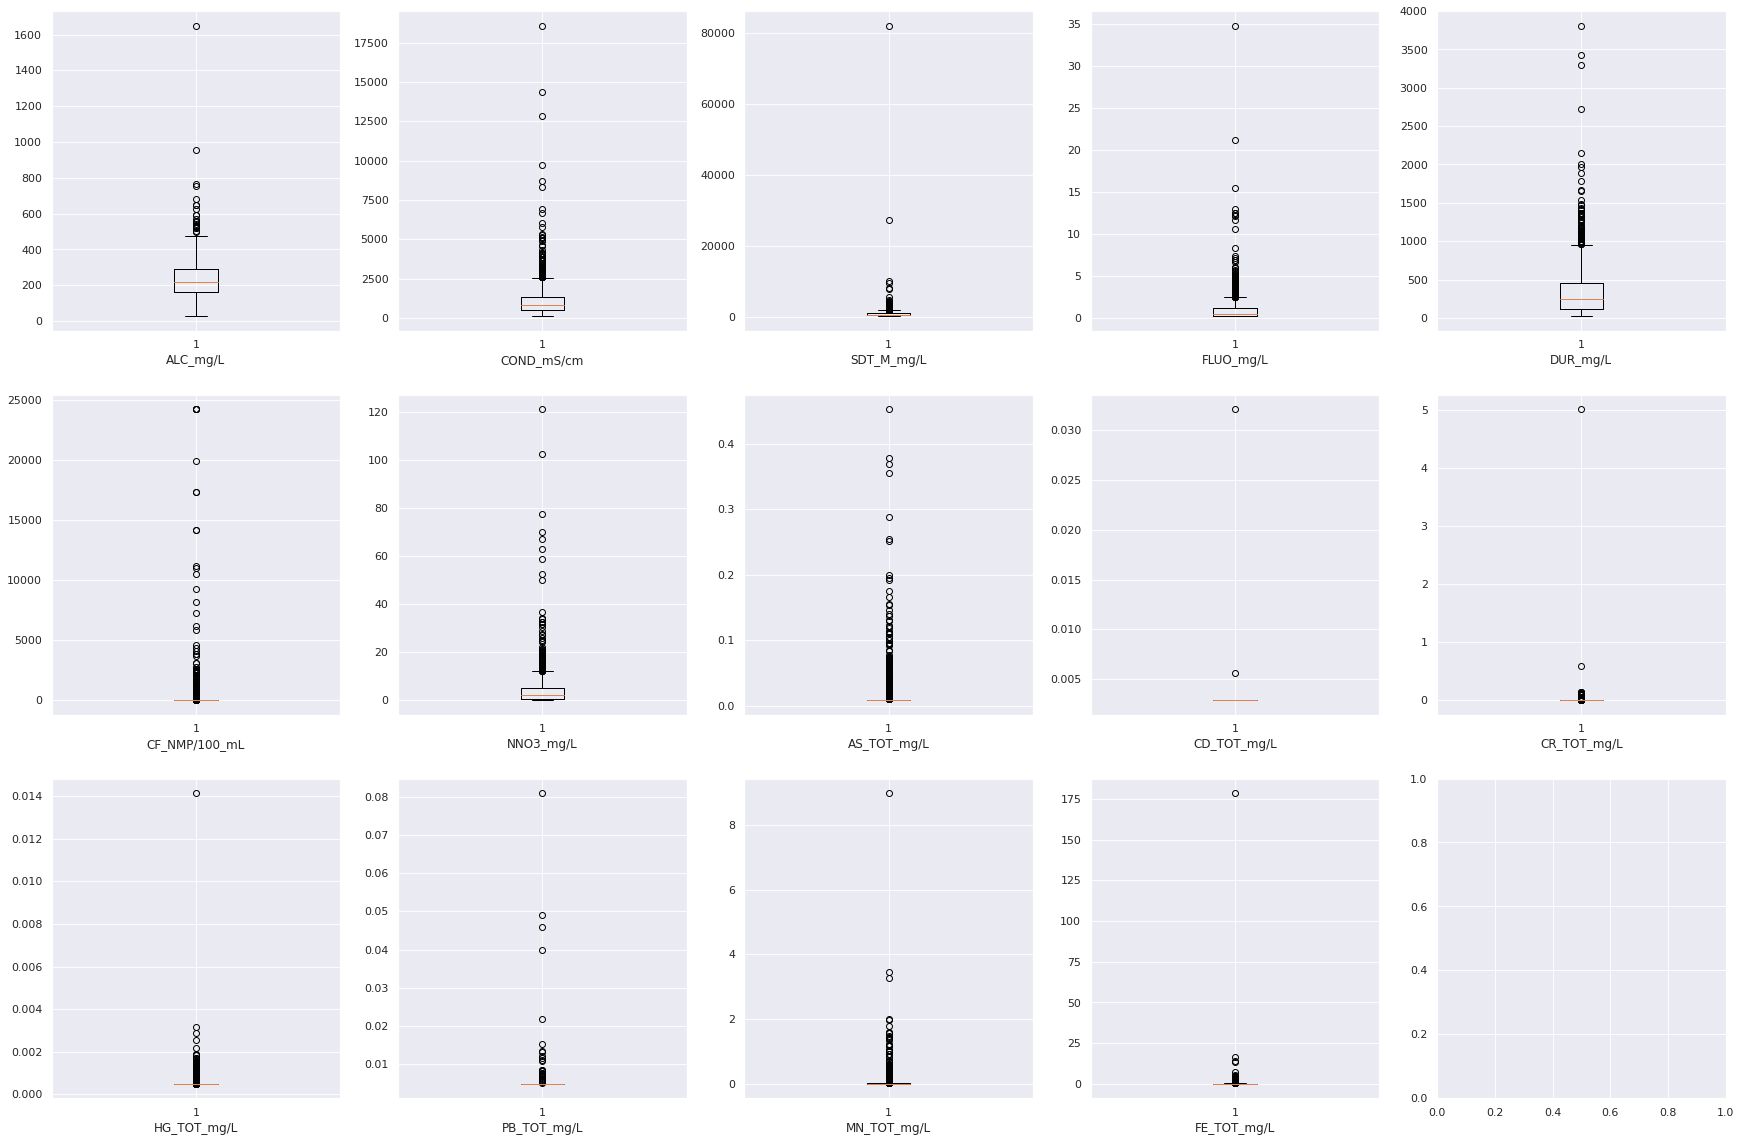

In [304]:
sns.set(rc={'figure.figsize':(30,20)})
fig, axes = plt.subplots(3, 5)
i = 0
for col in asub[num_nom_cal].columns:
  plt.subplot(3, 5,i+1) 
  plt.boxplot(asub[col]) 
  plt.xlabel(asub[num_nom_cal].columns[i])
  i = i + 1

Todas tienen valores extremos en general.


### Identificando tendencias centrales promedio, media, mediana, medidas de dispersión, máximo, mínimo.

In [305]:
asub[num_nom_cal].describe(include='all')# aqui incluimos todos los registros de las variables numericas

,ALC_mg/L,COND_mS/cm,SDT_M_mg/L,FLUO_mg/L,DUR_mg/L,CF_NMP/100_mL,NNO3_mg/L,AS_TOT_mg/L,CD_TOT_mg/L,CR_TOT_mg/L,HG_TOT_mg/L,PB_TOT_mg/L,MN_TOT_mg/L,FE_TOT_mg/L
count,1054.000000,1054.000000,1054.000000,1054.000000,1054.000000,1054.000000,1054.000000,1054.000000,1054.000000,1054.000000,1054.000000,1054.000000,1054.000000,1054.000000
mean,234.695266,1142.726471,896.945797,1.077048,349.891213,359.727249,4.321591,0.018741,0.002930,0.013273,0.000548,0.005188,0.072955,0.412197
std,111.147849,1248.990617,2765.757924,1.931890,360.962323,2065.706973,8.378363,0.035260,0.000903,0.155416,0.000471,0.003284,0.378857,5.574309
min,26.640000,110.000000,101.200000,0.190000,19.900000,1.090000,0.019000,0.009000,0.002900,0.004900,0.000490,0.004900,0.001490,0.024900
25%,164.257500,506.000000,338.050000,0.269475,121.512000,1.090000,0.651667,0.009000,0.002900,0.004900,0.000490,0.004900,0.001490,0.024900
50%,215.825000,820.000000,551.400000,0.506950,245.994450,1.090000,2.082916,0.009000,0.002900,0.004900,0.000490,0.004900,0.001490,0.046900
75%,292.930000,1328.000000,915.600000,1.142400,455.617200,10.750000,5.190385,0.009000,0.002900,0.004900,0.000490,0.004900,0.009830,0.172275
max,1650.000000,18577.000000,82170.000000,34.803300,3810.692200,24196.000000,121.007813,0.452200,0.032110,5.003200,0.014150,0.080900,8.982000,178.615000


In [306]:
asub[num_nom_cal].median()#agregamos la mediana que no está includia en el metodo describe()

ALC_mg/L         215.825000
COND_mS/cm       820.000000
SDT_M_mg/L       551.400000
FLUO_mg/L          0.506950
DUR_mg/L         245.994450
CF_NMP/100_mL      1.090000
NNO3_mg/L          2.082916
AS_TOT_mg/L        0.009000
CD_TOT_mg/L        0.002900
CR_TOT_mg/L        0.004900
HG_TOT_mg/L        0.000490
PB_TOT_mg/L        0.004900
MN_TOT_mg/L        0.001490
FE_TOT_mg/L        0.046900
dtype: float64

Donde podemos observar que los máximos y mínimos de cada columna de calidad se encuentran en magnitudes muy diferentes. Por lo que podría en un futuro ayudar escalar los datos. Así mismo, al ver los boxplots y al comparar el valor del tercer cuartil contra su máximo valor en todas las variables de calidad, podemos ver que existen outliers. Observemos más a detalle:

 ### Identificar medidas de posición no centrales, los cuartiles, outliers.  

In [307]:
def find_outliers_IQR(df):
   q1=df.quantile(0.25)
   q3=df.quantile(0.75)
   IQR=q3-q1
   outliers = df[((df<(q1-1.5*IQR)) | (df>(q3+1.5*IQR)))]
   return outliers

In [308]:
for col in asub[num_nom_cal].columns:
  outliers = find_outliers_IQR(asub[col])
  print('\033[1m' + col + '\033[0m')
  print('number of outliers:', '\033[1m' + str(len(outliers))+ '\033[0m', 'max outlier value:', '\033[1m'+ str(outliers.max()) + '\033[0m', 'min outlier value:','\033[1m' + str(outliers.min()) + '\033[0m')

ALC_mg/L
number of outliers: 22 max outlier value: 1650.0 min outlier value: 497.0
COND_mS/cm
number of outliers: 82 max outlier value: 18577.0 min outlier value: 2580.0
SDT_M_mg/L
number of outliers: 90 max outlier value: 82170.0 min outlier value: 1812.0
FLUO_mg/L
number of outliers: 104 max outlier value: 34.8033 min outlier value: 2.4666
DUR_mg/L
number of outliers: 62 max outlier value: 3810.6922 min outlier value: 959.17
CF_NMP/100_mL
number of outliers: 236 max outlier value: 24196.0 min outlier value: 31.0
NNO3_mg/L
number of outliers: 69 max outlier value: 121.007813 min outlier value: 12.039454
AS_TOT_mg/L
number of outliers: 250 max outlier value: 0.4522 min outlier value: 0.01
CD_TOT_mg/L
number of outliers: 2 max outlier value: 0.03211 min outlier value: 0.0056
CR_TOT_mg/L
number of outliers: 210 max outlier value: 5.0032 min outlier value: 0.005
HG_TOT_mg/L
number of outliers: 97 max outlier value: 0.01415 min outlier value: 0.0005
PB_TOT_mg/L
number of outliers: 30 max o

### A continuación tenemos las graficas **Pairplot** de las variables numericas y sus relaciones entre ellas:

In [309]:
sns.set(style="ticks", color_codes=True)

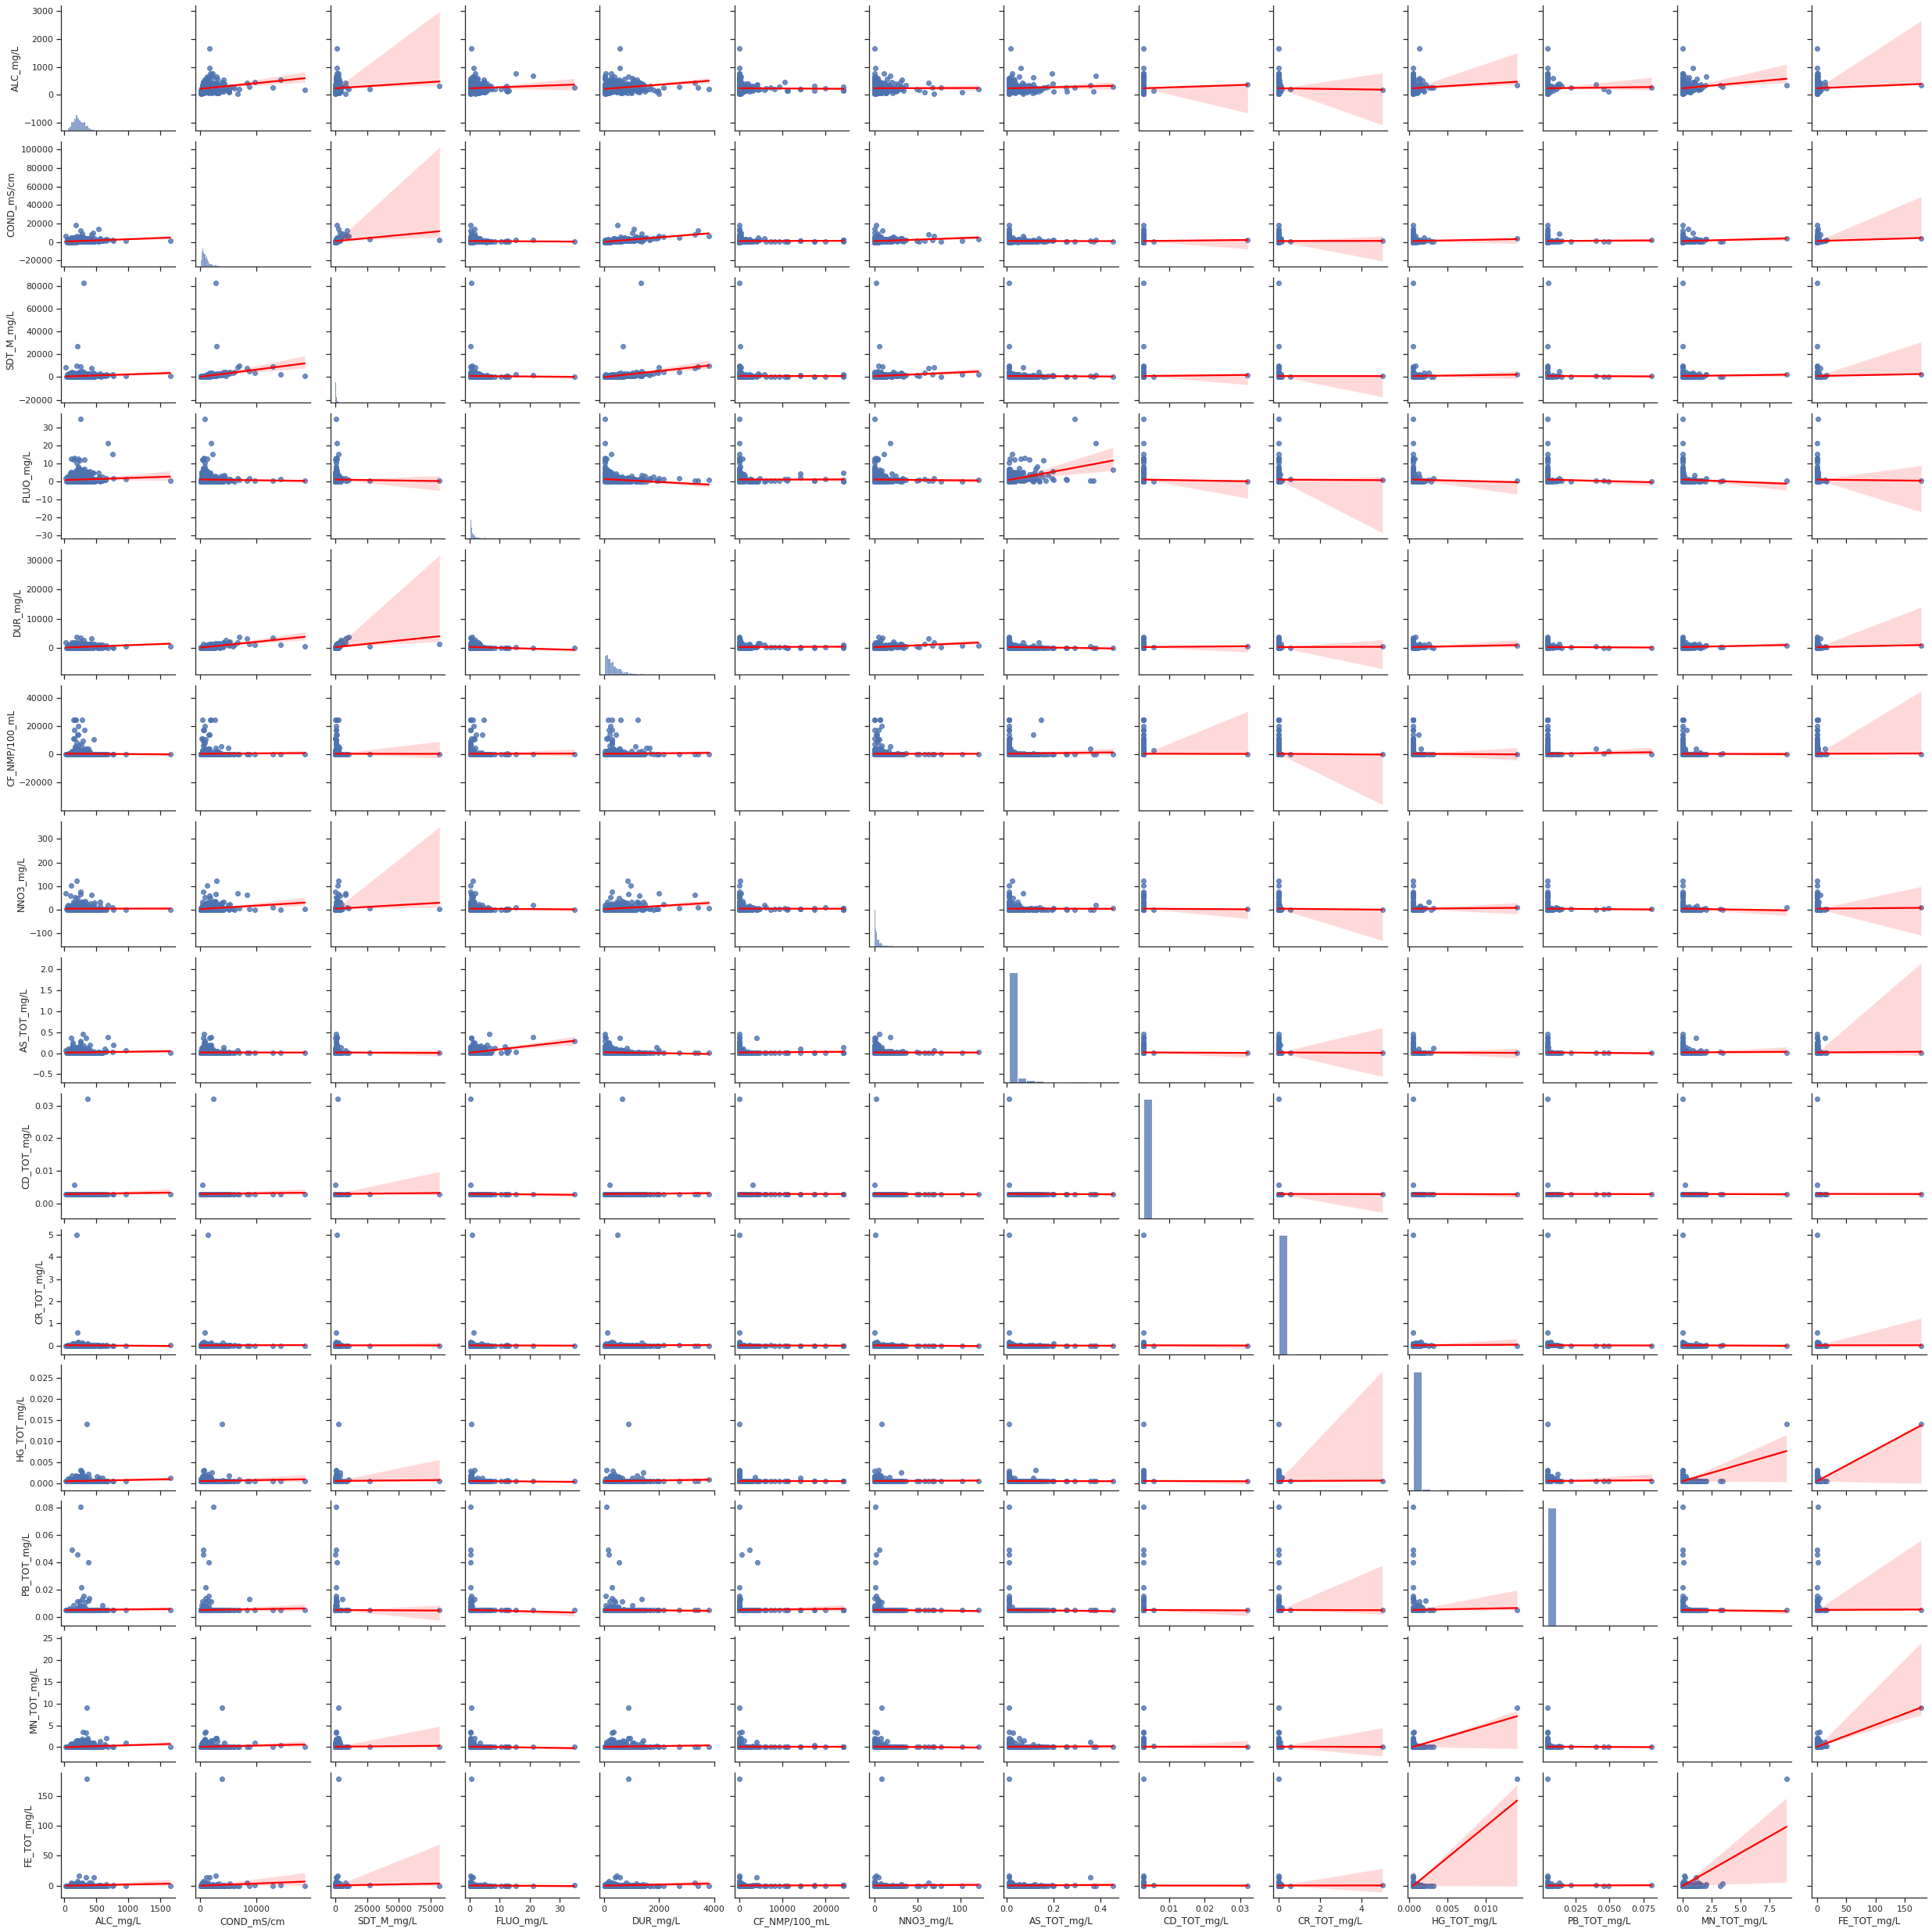

In [310]:
#grafico de pairplot de las numericas
sns.pairplot(asub[num_nom_cal], kind="reg", plot_kws={'line_kws':{'color':'red'}})

###Veamos ahora el **mapa de correlación** de las numéricas:

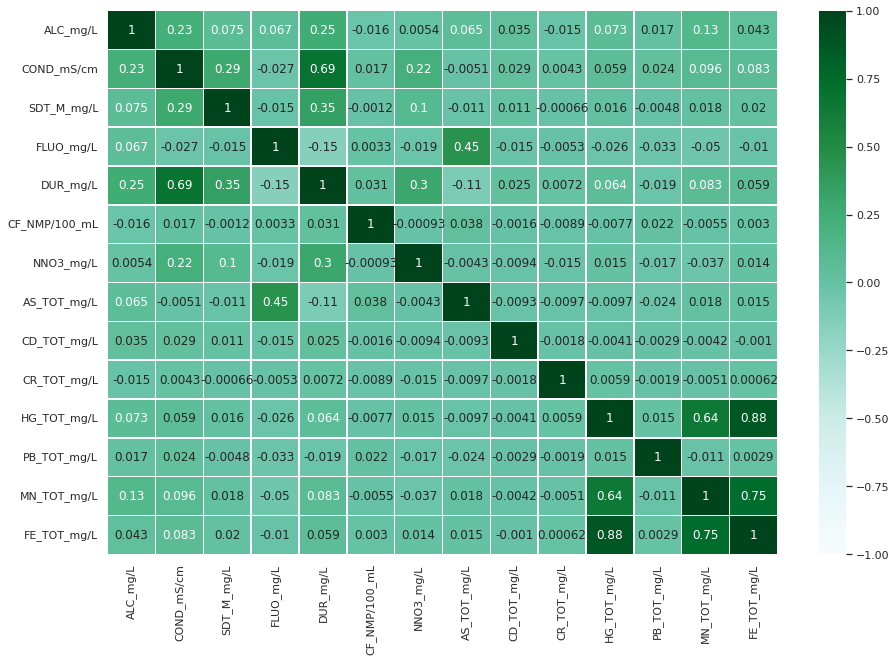

In [311]:
corr_num = asub[num_nom_cal].corr()

sns.set(rc = {'figure.figsize':(15,10)})
sns.heatmap(corr_num, vmin = -1, vmax = 1, cmap = "BuGn", annot= True, linewidths=0.5)

Donde obtenemos la máxima correlación de cada variable:

In [312]:
max_corr_list = list()
max_5_corr_list = list()
for col in corr_num.columns:
  max_corr = list()
  max = corr_num[col].abs().nlargest(2)[1]
  indx = corr_num[corr_num[col].abs()==max].index.values[0]
  max_corr.append(col);max_corr.append(corr_num[col][indx]);max_corr.append(indx)
  max_corr_list.append(max_corr)
  print(col + ':',corr_num[col][indx], 'con', indx)

ALC_mg/L: 0.2518585492539025 con DUR_mg/L
COND_mS/cm: 0.6927312949334768 con DUR_mg/L
SDT_M_mg/L: 0.34701352971258925 con DUR_mg/L
FLUO_mg/L: 0.4478980890511165 con AS_TOT_mg/L
DUR_mg/L: 0.6927312949334768 con COND_mS/cm
CF_NMP/100_mL: 0.038277258282501066 con AS_TOT_mg/L
NNO3_mg/L: 0.30192642619527127 con DUR_mg/L
AS_TOT_mg/L: 0.4478980890511165 con FLUO_mg/L
CD_TOT_mg/L: 0.03473889468020798 con ALC_mg/L
CR_TOT_mg/L: -0.015172856324131906 con NNO3_mg/L
HG_TOT_mg/L: 0.8781341883817256 con FE_TOT_mg/L
PB_TOT_mg/L: -0.032821943501716695 con FLUO_mg/L
MN_TOT_mg/L: 0.7454843568423366 con FE_TOT_mg/L
FE_TOT_mg/L: 0.8781341883817256 con HG_TOT_mg/L


Obtenemos las 5 correlaciones más fuertes:

In [313]:
def Nmaxelements(list1, N):
    final_list = []
    for i in range(0, N):
        max1 = 0       
        for j in range(len(list1)):    
            if abs(list1[j]) > abs(max1) and list1[j] not in final_list:
                max1 = list1[j];             
        list1.remove(max1);
        final_list.append(max1)       
    return final_list

In [314]:
all_values = list()
for col in corr_num.columns:
  for indx in corr_num.index:
    if corr_num[col][indx] != 1:
      all_values.append(corr_num[col][indx])

for val in Nmaxelements(all_values,5):
  break_1 = False
  for col in corr_num.columns:
    for indx in corr_num.index:
      if corr_num[col][indx] == val:
        print(col,'con',indx,'con',val)
        break_1 = True
        break
    if break_1:
      break

HG_TOT_mg/L con FE_TOT_mg/L con 0.8781341883817256
MN_TOT_mg/L con FE_TOT_mg/L con 0.7454843568423366
COND_mS/cm con DUR_mg/L con 0.6927312949334768
HG_TOT_mg/L con MN_TOT_mg/L con 0.6420641337604803
FLUO_mg/L con AS_TOT_mg/L con 0.4478980890511165


### Ahora veamos los **countplots** de las categorías:

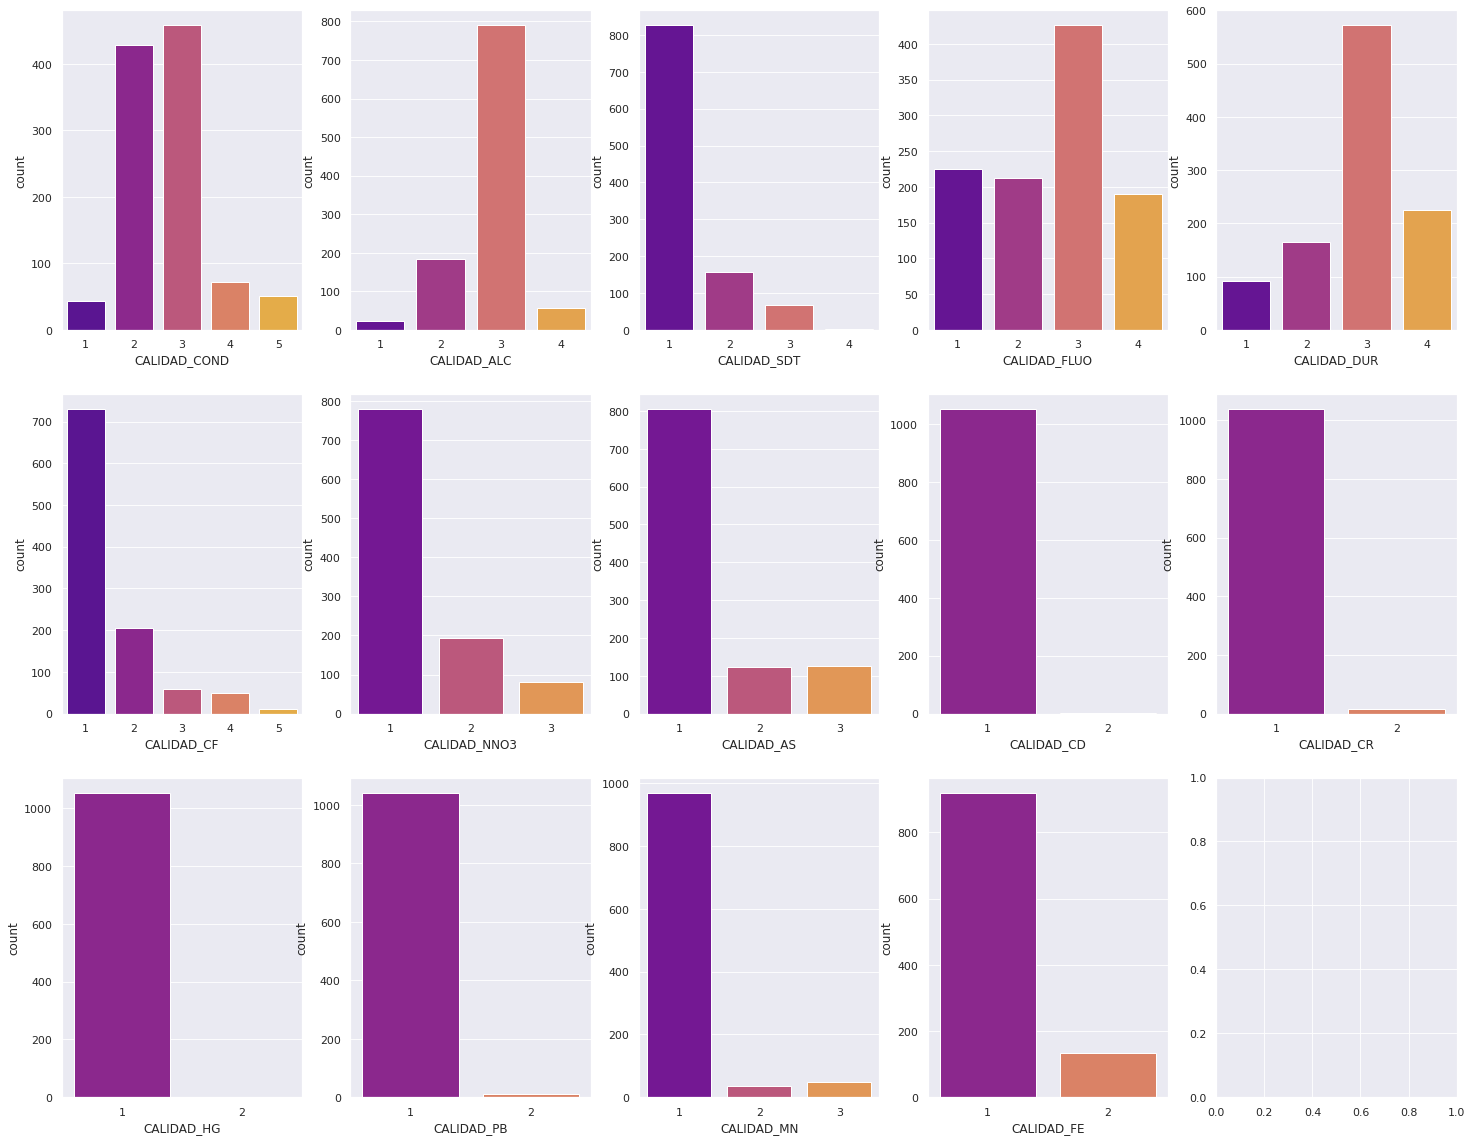

In [315]:
sns.set(rc={'figure.figsize':(25,20)})
fig, axes = plt.subplots(3, 5)
i = 0
for col in asub[cat_nom_cal].columns:
  plt.subplot(3, 5,i+1) 
  sns.countplot(x=asub[col],data=asub,palette='plasma')
  plt.xlabel(asub[cat_nom_cal].columns[i])
  i = i + 1

Vemos claramente los bines de cada variable ya codificados de manera Discreta con valores 1,2,3,etcetera cuando hicimos la limpieza y conversión

### Preparar los datos 

In [316]:
trans_asub = asub[['CLAVE'] + num_nom_geo + cat_nom + num_nom_cal + cat_nom_cal + y_nom].copy()

In [317]:
trans_asub[num_nom_cal]

,ALC_mg/L,COND_mS/cm,SDT_M_mg/L,FLUO_mg/L,DUR_mg/L,CF_NMP/100_mL,NNO3_mg/L,AS_TOT_mg/L,CD_TOT_mg/L,CR_TOT_mg/L,HG_TOT_mg/L,PB_TOT_mg/L,MN_TOT_mg/L,FE_TOT_mg/L
0,229.990,940.0,603.6000,0.9766,213.7320,1.09,4.184656,0.0161,0.0029,0.0049,0.00049,0.0049,0.00149,0.08910
1,231.990,608.0,445.4000,0.9298,185.0514,1.09,5.750110,0.0134,0.0029,0.0049,0.00049,0.0049,0.00149,0.02490
2,204.920,532.0,342.0000,1.8045,120.7190,1.09,1.449803,0.0370,0.0029,0.0049,0.00049,0.0049,0.00149,0.02490
3,327.000,686.0,478.6000,1.1229,199.8790,1.09,1.258597,0.0154,0.0029,0.0050,0.00049,0.0049,0.00149,0.02490
4,309.885,1841.0,1179.0000,0.2343,476.9872,291.00,15.672251,0.0090,0.0029,0.0049,0.00049,0.0049,0.00149,0.02490
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1049,231.045,2350.0,1545.8000,0.1900,752.0960,1.09,14.615488,0.0090,0.0029,0.0049,0.00049,0.0049,0.00149,0.02490
1050,256.000,529.0,297.0000,0.1900,273.0000,1.09,77.392000,0.0090,0.0029,0.0049,0.00049,0.0049,0.00709,0.07578
1051,330.690,2600.0,1873.0000,0.7574,660.2126,620.00,36.477104,0.0090,0.0029,0.0049,0.00049,0.0049,0.02420,0.21290
1052,193.140,873.0,690.6667,0.7108,406.3680,1.09,0.019000,0.0090,0.0029,0.0049,0.00049,0.0049,0.01200,0.17860


Buscamos que tipo de transformación logra normalizar más los datos:

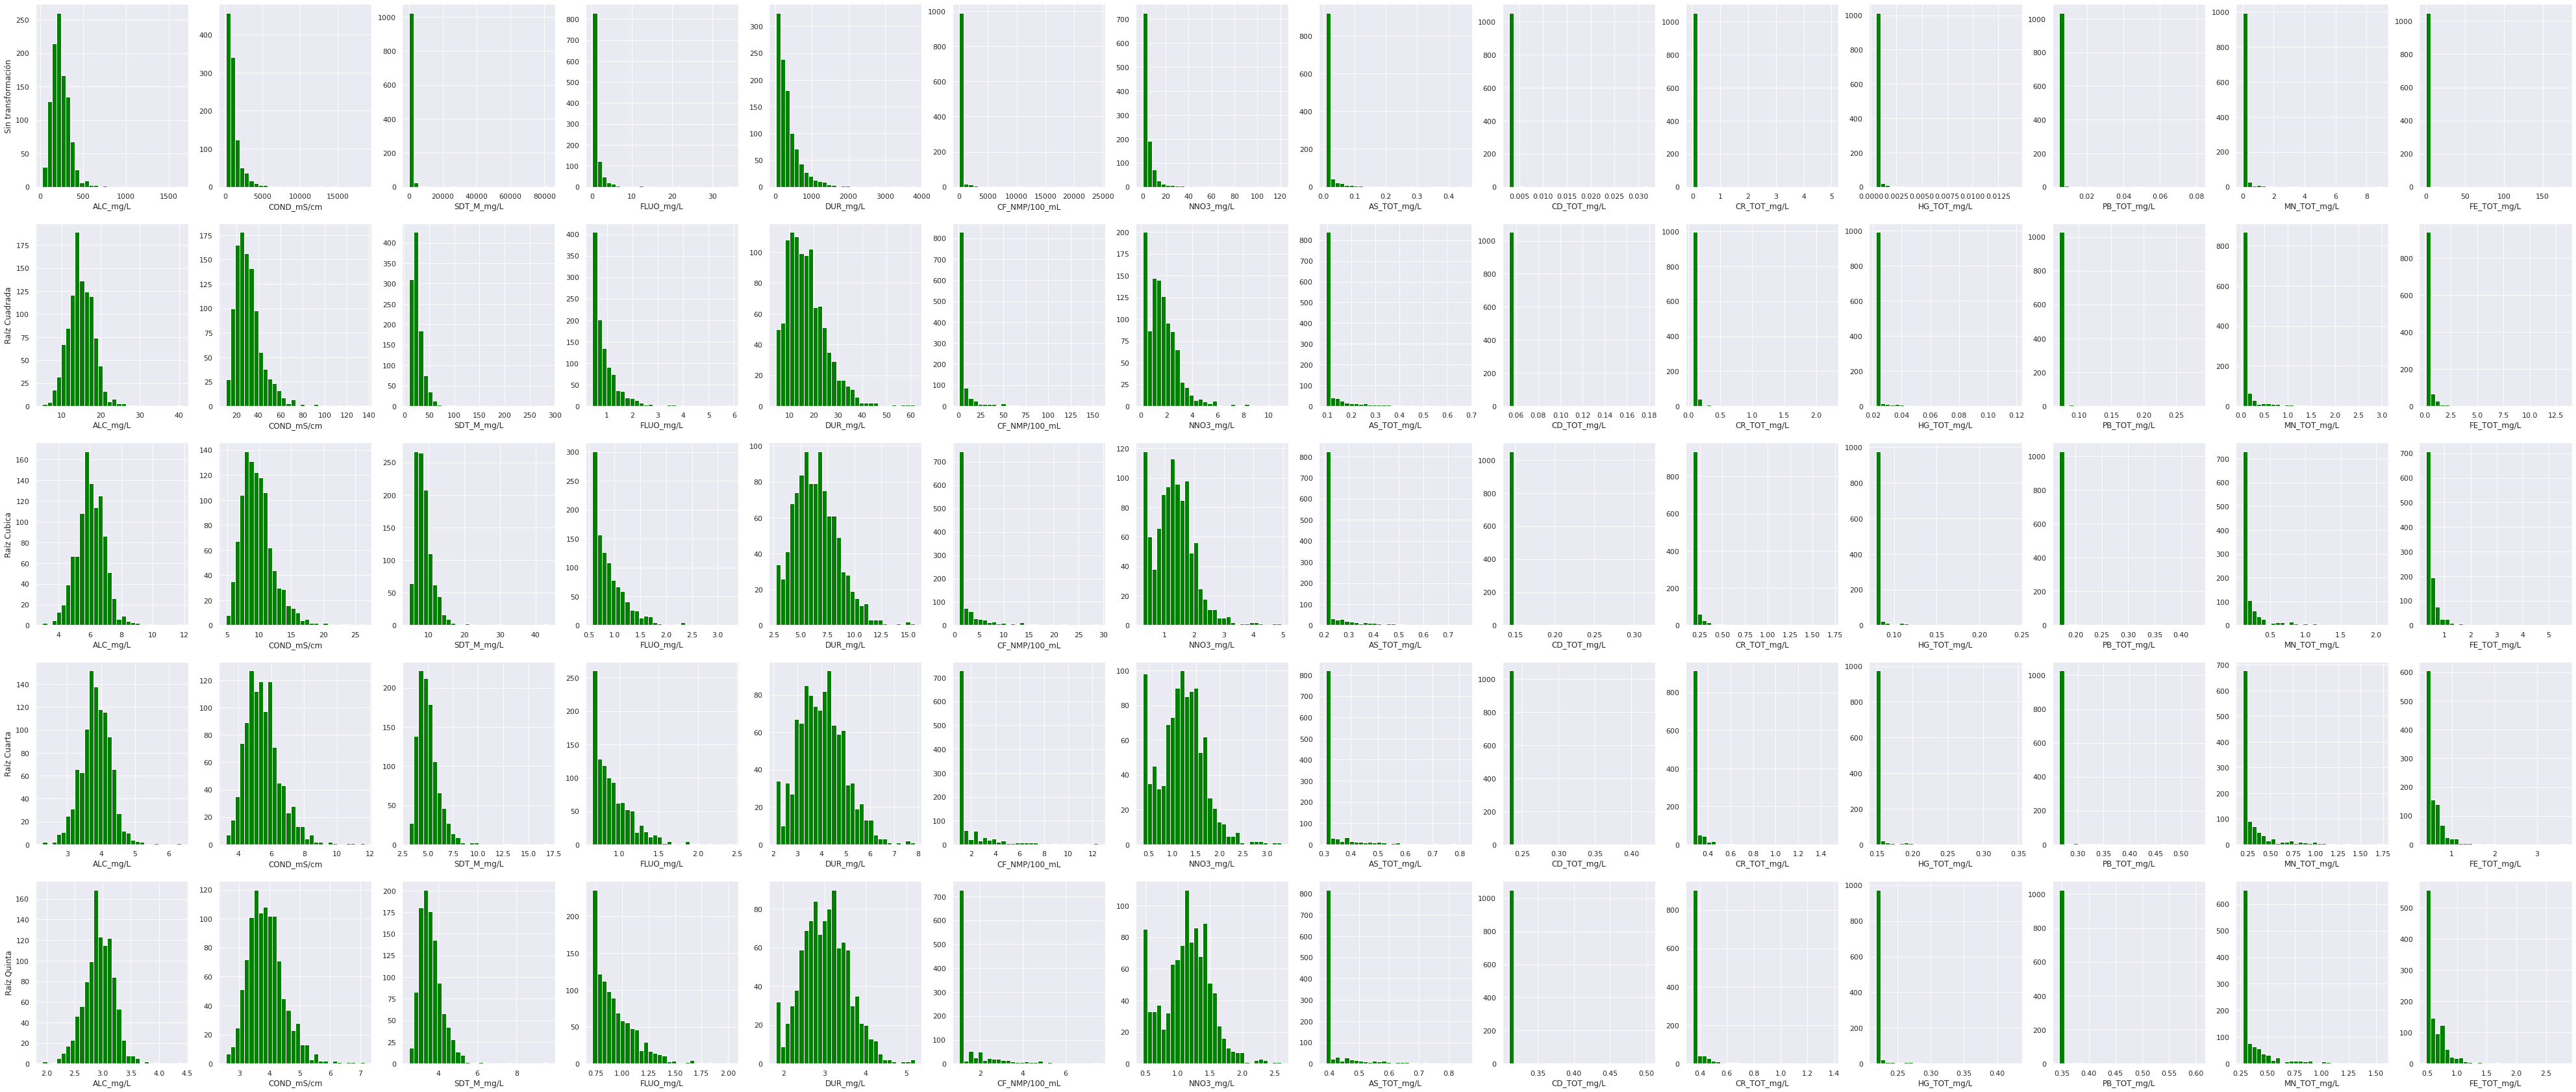

In [318]:
df_transform = trans_asub[num_nom_cal]
nvar = len(trans_asub[num_nom_cal].columns)
nplots = 5
sns.set(rc={'figure.figsize':(nvar*5,30)})
k=0
fig, axes = plt.subplots(nplots, nvar)   
for k in range(0,nvar):  
  plt.subplot(nplots, nvar,k+1) 

  Transf0 = trans_asub[num_nom_cal].iloc[:,k].to_numpy().reshape(-1, 1) 
  plt.hist(Transf0, bins=30,color='green') 
  plt.xlabel(df_transform.columns[k])
  if k==0:
    plt.ylabel('Sin transformación')
  
  plt.subplot(nplots, nvar,k+1+nvar*1)    
  Transf1 = np.sqrt(Transf0)       
  plt.hist(Transf1, bins=30,color='green')                      
  plt.xlabel(df_transform.columns[k])
  if k==0:
    plt.ylabel('Raíz Cuadrada')

  plt.subplot(nplots, nvar,k+1+nvar*2)  
  Transf2 = np.power(Transf0,1/3)    
  plt.hist(Transf2, bins=30,color='green')                   
  plt.xlabel(df_transform.columns[k])
  if k==0:
    plt.ylabel('Raíz Cubica')

  plt.subplot(nplots, nvar,k+1+nvar*3)    
  Transf3 = np.power(Transf0,1/4)        
  plt.hist(Transf3, bins=30,color='green')                   
  plt.xlabel(df_transform.columns[k])
  if k==0:
    plt.ylabel('Raíz Cuarta')  

  plt.subplot(nplots, nvar,k+1+nvar*4)  
  Transf4 = np.power(Transf0,1/5)     
  plt.hist(Transf4, bins=30,color='green')                   
  plt.xlabel(df_transform.columns[k])
  if k==0:
    plt.ylabel('Raíz Quinta')

Observamos que, aunque a más de la mitad no les hace efecto, la que mejor comportamiento tiene es la raíz cubica:

In [319]:
for col in trans_asub[num_nom_cal].columns:
  trans_asub[col] = pd.DataFrame(np.power(trans_asub[col],1/3), columns = [col])

In [320]:
trans_asub[num_nom_cal]

,ALC_mg/L,COND_mS/cm,SDT_M_mg/L,FLUO_mg/L,DUR_mg/L,CF_NMP/100_mL,NNO3_mg/L,AS_TOT_mg/L,CD_TOT_mg/L,CR_TOT_mg/L,HG_TOT_mg/L,PB_TOT_mg/L,MN_TOT_mg/L,FE_TOT_mg/L
0,6.126837,9.795861,8.451162,0.992138,5.978926,1.029142,1.611461,0.252508,0.142604,0.169850,0.078837,0.16985,0.114216,0.446642
1,6.144545,8.471647,7.636894,0.976030,5.698547,1.029142,1.791535,0.237521,0.142604,0.169850,0.078837,0.16985,0.114216,0.292011
2,5.895601,8.102839,6.993191,1.217453,4.942256,1.029142,1.131800,0.333222,0.142604,0.169850,0.078837,0.16985,0.114216,0.292011
3,6.889419,8.819447,7.822116,1.039394,5.846856,1.029142,1.079681,0.248794,0.142604,0.170998,0.078837,0.16985,0.114216,0.292011
4,6.767062,12.256071,10.564232,0.616487,7.813319,6.626705,2.502518,0.208008,0.142604,0.169850,0.078837,0.16985,0.114216,0.292011
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1049,6.136191,13.295029,11.562483,0.574890,9.094059,1.029142,2.444956,0.208008,0.142604,0.169850,0.078837,0.16985,0.114216,0.292011
1050,6.349604,8.087579,6.671940,0.574890,6.487154,1.029142,4.261528,0.208008,0.142604,0.169850,0.078837,0.16985,0.192109,0.423173
1051,6.915236,13.750689,12.326674,0.911539,8.707522,8.527019,3.316450,0.208008,0.142604,0.169850,0.078837,0.16985,0.289249,0.597116
1052,5.780394,9.557363,8.839401,0.892447,7.406957,1.029142,0.266840,0.208008,0.142604,0.169850,0.078837,0.16985,0.228943,0.563154


Escalamos los datos numéricos:

In [321]:
scaled_features = MinMaxScaler((1,10)).fit_transform(asub[num_nom_cal].values)
num_scaled = pd.DataFrame(scaled_features, columns = num_nom_cal)

for col in num_nom_cal:
  trans_asub[col] = num_scaled[col]

trans_asub[num_nom_cal]

,ALC_mg/L,COND_mS/cm,SDT_M_mg/L,FLUO_mg/L,DUR_mg/L,CF_NMP/100_mL,NNO3_mg/L,AS_TOT_mg/L,CD_TOT_mg/L,CR_TOT_mg/L,HG_TOT_mg/L,PB_TOT_mg/L,MN_TOT_mg/L,FE_TOT_mg/L
0,2.127384,1.404505,1.055095,1.204528,1.460191,1.000000,1.309871,1.144179,1.0,1.00000,1.0,1.0,1.000000,1.003235
1,2.138472,1.242703,1.037746,1.192360,1.392098,1.000000,1.426320,1.089350,1.0,1.00000,1.0,1.0,1.000000,1.000000
2,1.988394,1.205664,1.026407,1.419795,1.239362,1.000000,1.106433,1.568592,1.0,1.00000,1.0,1.0,1.000000,1.000000
3,2.665213,1.280717,1.041387,1.242569,1.427301,1.000000,1.092210,1.129964,1.0,1.00018,1.0,1.0,1.000000,1.000000
4,2.570326,1.843613,1.118196,1.011519,2.085205,1.107840,2.164399,1.000000,1.0,1.00000,1.0,1.0,1.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1049,2.133233,2.091677,1.158421,1.000000,2.738361,1.000000,2.085790,1.000000,1.0,1.00000,1.0,1.0,1.000000,1.000000
1050,2.271585,1.204202,1.021472,1.000000,1.600903,1.000000,6.755549,1.000000,1.0,1.00000,1.0,1.0,1.005612,1.002564
1051,2.685670,2.213516,1.194303,1.147533,2.520213,1.230222,3.712011,1.000000,1.0,1.00000,1.0,1.0,1.022759,1.009474
1052,1.923085,1.371852,1.064643,1.135416,1.917542,1.000000,1.000000,1.000000,1.0,1.00000,1.0,1.0,1.010533,1.007746


**Y finalmente tenemos nuestro dataframe transformado y con las variables que podemos utilizar para el análisis:**


In [322]:
trans_asub

,CLAVE,LONGITUD,LATITUD,ORGANISMO_DE_CUENCA,SUBTIPO,ALC_mg/L,COND_mS/cm,SDT_M_mg/L,FLUO_mg/L,DUR_mg/L,...,CALIDAD_CF,CALIDAD_NNO3,CALIDAD_AS,CALIDAD_CD,CALIDAD_CR,CALIDAD_HG,CALIDAD_PB,CALIDAD_MN,CALIDAD_FE,SEMAFORO
0,DLAGU6,-102.02210,22.20887,6.0,5.0,2.127384,1.404505,1.055095,1.204528,1.460191,...,1,1,2,1,1,1,1,1,1,1
1,DLAGU6516,-102.20075,21.99958,6.0,5.0,2.138472,1.242703,1.037746,1.192360,1.392098,...,1,2,2,1,1,1,1,1,1,1
2,DLAGU7,-102.28801,22.36685,6.0,5.0,1.988394,1.205664,1.026407,1.419795,1.239362,...,1,1,3,1,1,1,1,1,1,3
3,DLAGU9,-102.29449,22.18435,6.0,5.0,2.665213,1.280717,1.041387,1.242569,1.427301,...,1,1,2,1,1,1,1,1,1,1
4,DLBAJ107,-110.24480,23.45138,10.0,5.0,2.570326,1.843613,1.118196,1.011519,2.085205,...,3,3,1,1,1,1,1,1,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1049,OCRBR5101M1,-99.54191,24.76036,12.0,5.0,2.133233,2.091677,1.158421,1.000000,2.738361,...,1,3,1,1,1,1,1,1,1,3
1050,OCRBR5102M1,-99.70099,24.78280,12.0,5.0,2.271585,1.204202,1.021472,1.000000,1.600903,...,1,3,1,1,1,1,1,1,1,3
1051,OCRBR5105M2,-99.82249,25.55197,12.0,5.0,2.685670,2.213516,1.194303,1.147533,2.520213,...,3,3,1,1,1,1,1,1,1,3
1052,OCRBR5106M1,-100.32683,24.80118,12.0,5.0,1.923085,1.371852,1.064643,1.135416,1.917542,...,1,1,1,1,1,1,1,1,1,1


## **Realizar análisis para encontrar si existe una relación entre la calidad del agua y su ubicación geográfica a través de K- means.**

Primero observamos la distribución de las clases en el semáforo:

Class=1, n=427 (40.512%)
Class=3, n=382 (36.243%)
Class=2, n=245 (23.245%)


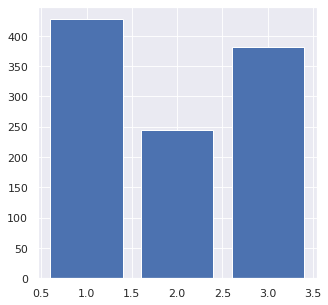

In [323]:
sns.set(rc={'figure.figsize':(5,5)})
y = trans_asub['SEMAFORO']
counter = Counter(y)
for k,v in counter.items():
	per = v / len(y) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
plt.bar(counter.keys(), counter.values())
plt.show()

Donde observamos que la clase mayoritaria es el semáforo color verde con 40.5%, seguido del rojo con 36.24%, y finalmente el amarillo con 23.24%

Ahora transformamos nuestra dataframe en una geo dataframe para trabajar con ella en base a longitud y latitud:

In [324]:
df_geo = trans_asub.copy()

df_geo["Coordinates"] = list(zip(df_geo.LONGITUD, df_geo.LATITUD))
df_geo["Coordinates"] = df_geo["Coordinates"].apply(Point)
df_geo.head()

,CLAVE,LONGITUD,LATITUD,ORGANISMO_DE_CUENCA,SUBTIPO,ALC_mg/L,COND_mS/cm,SDT_M_mg/L,FLUO_mg/L,DUR_mg/L,...,CALIDAD_NNO3,CALIDAD_AS,CALIDAD_CD,CALIDAD_CR,CALIDAD_HG,CALIDAD_PB,CALIDAD_MN,CALIDAD_FE,SEMAFORO,Coordinates
0,DLAGU6,-102.02210,22.20887,6.0,5.0,2.127384,1.404505,1.055095,1.204528,1.460191,...,1,2,1,1,1,1,1,1,1,POINT (-102.0221 22.20887)
1,DLAGU6516,-102.20075,21.99958,6.0,5.0,2.138472,1.242703,1.037746,1.192360,1.392098,...,2,2,1,1,1,1,1,1,1,POINT (-102.20075 21.99958)
2,DLAGU7,-102.28801,22.36685,6.0,5.0,1.988394,1.205664,1.026407,1.419795,1.239362,...,1,3,1,1,1,1,1,1,3,POINT (-102.28801 22.36685)
3,DLAGU9,-102.29449,22.18435,6.0,5.0,2.665213,1.280717,1.041387,1.242569,1.427301,...,1,2,1,1,1,1,1,1,1,POINT (-102.29449 22.18435)
4,DLBAJ107,-110.24480,23.45138,10.0,5.0,2.570326,1.843613,1.118196,1.011519,2.085205,...,3,1,1,1,1,1,1,1,3,POINT (-110.2448 23.45138)


In [325]:
gdf = gpd.GeoDataFrame(df_geo, geometry="Coordinates")


###La Inertia mide que tan bien un conjunto de datos esta siendo clusterizado por K-Means. Se calcula midiendo las distancias entre cada punto a su centroide y sacando el cuadrado de su distancia y sumando los cuadrados de dichas distancias de todos los puntos en ese cluster.

###Un buen modelo es aquel cuya INERTIA es baja y hay un numero bajo de clusters K, sin embargo es una situacion que hay que decidir ya que a medida que K se incrementa (clusters) la inertia decrece.

###Para encontrar el punto optimo de K para el dataset, utilizamos el metodo de ELBOW (Metodo de Codo) , para encontrar el punto donde el decremento en la INERTIA empieza a ser muy lento.

###Primeramente vamos a entrenar el modelo KMeans para una cantidad diferente de clusters y guardar el valor de Inertia de cada modelo entrenado. Y dibujamos la curva para encontrar el numero optimo de clusters.

Text(0.5, 1.0, 'Diferentes Valores de Inertia para los Diferentes Numeros de Clusters ')

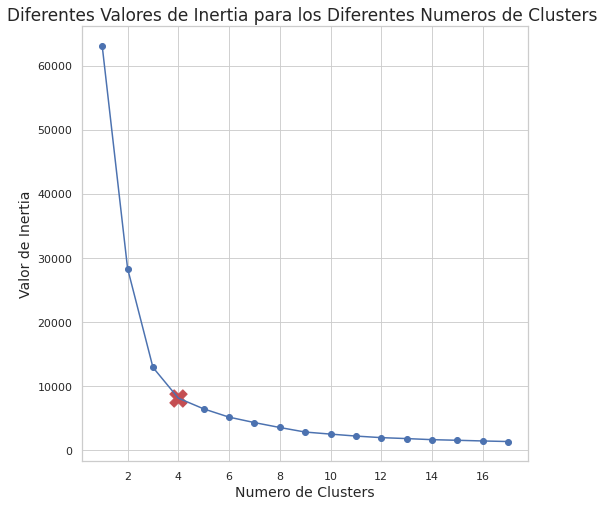

In [326]:
X = list(zip(gdf.LONGITUD, gdf.LATITUD))
MaxClusters = 18
# es una cantidad arbitraria que pusimos solo para para graficar

plt.rcParams['figure.figsize'] = [8,8]
sns.set_style("whitegrid")
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

inertia_list = []
for num_clusters in range(1, MaxClusters):
    kmeans_model = KMeans(n_clusters=num_clusters, init="k-means++")
    kmeans_model.fit(X)
    inertia_list.append(kmeans_model.inertia_)
    
# dibujamos la curva de inertia
plt.plot(range(1,MaxClusters),inertia_list)
plt.scatter(range(1,MaxClusters),inertia_list)
plt.scatter(4, inertia_list[3], marker="X", s=300, c="r")
plt.xlabel("Numero de Clusters", size=14)
plt.ylabel("Valor de Inertia", size=14)
plt.title("Diferentes Valores de Inertia para los Diferentes Numeros de Clusters ", size=17)

Donde podemos ver que a en base a la métrica de inertia, 4 clusters es la cantidad de almacenes ideales. Sin embargo, queremos descubrir si con KMeans podemos encontrar agrupaciones geográficas donde de acuerdo a la calidad del agua.

In [327]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)
centers = kmeans.cluster_centers_

In [328]:
#sns.set(rc={'figure.figsize':(5,5)})
for c in range(0,len(np.bincount(y_kmeans))):
  indices = list()
  indices = [i for i, x in enumerate(y_kmeans) if x == c]
  counter = Counter(df_geo['SEMAFORO'][indices])
  print('\033[1m' + 'Cluster ' + str(c) + '\033[0m')
  for k,v in counter.items():
    per = v / len(indices) * 100
    print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
  #plt.bar(counter.keys(), counter.values())
  #plt.show()

Cluster 0
Class=3, n=186 (57.944%)
Class=1, n=96 (29.907%)
Class=2, n=39 (12.150%)
Cluster 1
Class=3, n=67 (31.905%)
Class=1, n=95 (45.238%)
Class=2, n=48 (22.857%)
Cluster 2
Class=2, n=85 (52.469%)
Class=1, n=63 (38.889%)
Class=3, n=14 (8.642%)
Cluster 3
Class=1, n=173 (47.922%)
Class=3, n=115 (31.856%)
Class=2, n=73 (20.222%)


Donde observamos los porcentajes de cada clase para cada cluster. Y podemos ver que el mayor porcentaje en un cluster es de casi 60% de la clase de semáforo 3. Sin embargo, no es un numero particularmente alto como para indicar que existe una relación de clases en base a ubicación geográfica. Especialmente porque los otros 3 clusters no tienen una diferencia grande entre porcentajes de clases.

Iteremos ahora obteniendo el promedio de porcentaje de la clase máxima para cada cluster, para confirmar si existe o no una relación entre zona geográfica y clases:

In [329]:
N_max = 80

max_class = list()

for N in range(1,N_max):
  kmeans = KMeans(n_clusters=N)
  kmeans.fit(X)
  y_kmeans = kmeans.predict(X)
  avg_list1 = list()
  for c in range(0,len(np.bincount(y_kmeans))):
    indices = list()
    indices = [i for i, x in enumerate(y_kmeans) if x == c]
    counter = Counter(df_geo['SEMAFORO'][indices])
    avg_list2 = list()
    for k,v in counter.items():
      per = v / len(indices) * 100
      avg_list2.append(per)
    avg_list1.append(np.max(avg_list2))
  centers = kmeans.cluster_centers_
  max_class.append([N,sum(avg_list1) / len(avg_list1)])

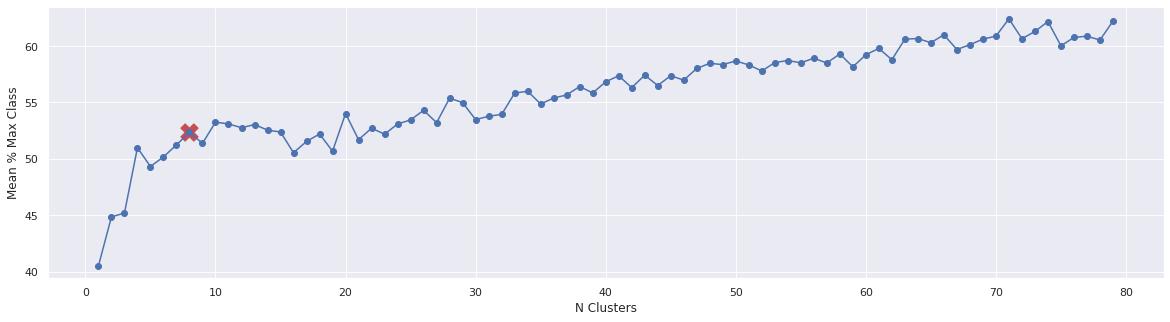

In [330]:
sns.set(rc={'figure.figsize':(20,5)})
plt.plot(pd.DataFrame(max_class)[0], pd.DataFrame(max_class)[1], '-o')
plt.scatter(8, pd.DataFrame(max_class)[1][7], marker="X", s=300, c="r")
plt.xlabel('N Clusters')
plt.ylabel('Mean % Max Class')

plt.show()

Donde observamos que la tendencia es que entre mayor número de clases, mayor porcentaje alcanza la clase máxima para cada cluster. Sin embargo, no por mucho. Tiene sentido ya que, si pusiéramos un cluster alado de cada toma de agua, pues el porcentaje de la clase mayoritaria serian 100%, ya que solo existiria una valor de una clase por cluster.

Observamos su comportamiento con 8 clusters, que es el último punto donde el promedio del porcentaje de la clase mayoritaria tiene un incremento considerable:

In [331]:
kmeans = KMeans(n_clusters=8)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)
centers = kmeans.cluster_centers_

In [332]:
#sns.set(rc={'figure.figsize':(5,5)})
for c in range(0,len(np.bincount(y_kmeans))):
  indices = list()
  indices = [i for i, x in enumerate(y_kmeans) if x == c]
  counter = Counter(df_geo['SEMAFORO'][indices])
  print('\033[1m' + 'Cluster ' + str(c) + '\033[0m')
  for k,v in counter.items():
    per = v / len(indices) * 100
    print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
  #plt.bar(counter.keys(), counter.values())
  #plt.show()

Cluster 0
Class=2, n=13 (31.707%)
Class=3, n=6 (14.634%)
Class=1, n=22 (53.659%)
Cluster 1
Class=3, n=25 (32.051%)
Class=1, n=33 (42.308%)
Class=2, n=20 (25.641%)
Cluster 2
Class=1, n=108 (41.379%)
Class=3, n=115 (44.061%)
Class=2, n=38 (14.559%)
Cluster 3
Class=1, n=60 (58.252%)
Class=3, n=30 (29.126%)
Class=2, n=13 (12.621%)
Cluster 4
Class=2, n=72 (59.504%)
Class=1, n=41 (33.884%)
Class=3, n=8 (6.612%)
Cluster 5
Class=1, n=89 (52.976%)
Class=2, n=41 (24.405%)
Class=3, n=38 (22.619%)
Cluster 6
Class=3, n=15 (31.250%)
Class=2, n=22 (45.833%)
Class=1, n=11 (22.917%)
Cluster 7
Class=3, n=145 (61.966%)
Class=1, n=63 (26.923%)
Class=2, n=26 (11.111%)


Y aunque observamos que existe un incremento en el promedio, el valor máximo de clase mayoritaria en un cluster sigue siendo cercano 60%. Podemos concluir que no existe relación significativa entre el valor del semáforo y la ubicación geográfica.

## **Mostrar resultados de agrupamiento de latitudes y longitudes con K means en el mapa de México.**

Concluyendo en el punto anterior, volvemos al máximo de 4 clusters en base a la métrica de inertia:

In [333]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)
centers = kmeans.cluster_centers_

In [334]:
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
world = world.set_index("iso_a3")

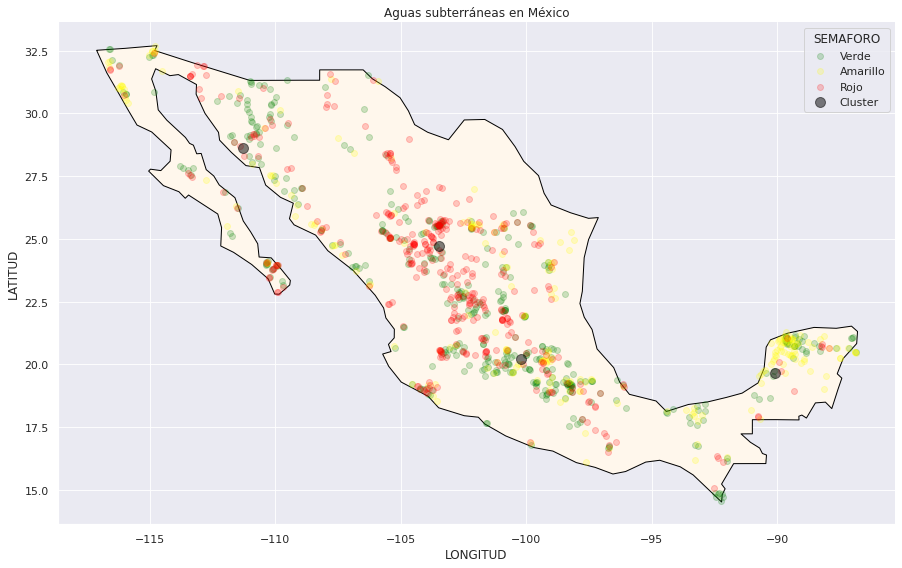

In [335]:
fig, gax = plt.subplots(figsize=(15,15))

world.query("name == 'Mexico'").plot(ax = gax, edgecolor='black', cmap='OrRd')

gdf.loc[gdf['SEMAFORO'] == 1].plot(ax=gax, color='green', alpha = 0.2, label='Verde')
gdf.loc[gdf['SEMAFORO'] == 2].plot(ax=gax, color='yellow', alpha = 0.2, label='Amarillo')
gdf.loc[gdf['SEMAFORO'] == 3].plot(ax=gax, color='red', alpha = 0.2, label='Rojo')
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=100, alpha=0.5, label='Cluster')
gax.legend(title = 'SEMAFORO')

gax.set_xlabel('LONGITUD')
gax.set_ylabel('LATITUD')
gax.set_title('Aguas subterráneas en México')

gax.spines['top'].set_visible(False)
gax.spines['right'].set_visible(False)

plt.show()

Donde efectivamente, confirmamos que no existe una relación entre la calidad del agua y las coordenadas geográficas.

# **AGUAS SUPERFICIALES**

Cargamos la base de datos de Aguas Superficiales

In [336]:
url = 'http://201.116.60.46/Datos_de_calidad_del_agua_de_5000_sitios_de_monitoreo.zip'

df_asup = zip_to_df(url,'Datos_de_calidad_del_agua_de_sitios_de_monitoreo_de_aguas_superficiales_2020.csv',',')
df_asup.head(5)

,CLAVE,SITIO,ORGANISMO_DE_CUENCA,ESTADO,MUNICIPIO,CUENCA,CUERPO DE AGUA,TIPO,SUBTIPO,LONGITUD,...,CONTAMINANTES,CUMPLE_CON_DBO,CUMPLE_CON_DQO,CUMPLE_CON_SST,CUMPLE_CON_CF,CUMPLE_CON_E_COLI,CUMPLE_CON_ENTEROC,CUMPLE_CON_OD,CUMPLE_CON_TOX,GRUPO
0,DLAGU8,PRESA EL SAUCILLO 100M AGUAS ARRIBA DE LA CORTINA,LERMA SANTIAGO PACIFICO,AGUASCALIENTES,RINCON DE ROMOS,RIO SAN PEDRO,PRESA EL SAUCILLO,LENTICO,PRESA,-102.33911,...,"DQO,CF,",SI,NO,SI,NO,SI,ND,SI,SI,LENTICO
1,DLBAJ100,"LOS CABOS SEG 22, 2 ISA10B",PENINSULA DE BAJA CALIFORNIA,BAJA CALIFORNIA SUR,LOS CABOS,SAN JOSE DEL CABO,OCEANO PACIFICO,COSTERO,OCEANO-MAR,-109.84290,...,NaN,ND,ND,SI,ND,ND,SI,SI,SI,COSTERO
2,DLBAJ101,"LOS CABOS SEG 22, 1 ISA10B",PENINSULA DE BAJA CALIFORNIA,BAJA CALIFORNIA SUR,LOS CABOS,SAN LUCAS,OCEANO PACIFICO,COSTERO,OCEANO-MAR,-109.86442,...,NaN,ND,ND,SI,ND,ND,SI,SI,SI,COSTERO
3,DLBAJ102,LOS CABOS 3,PENINSULA DE BAJA CALIFORNIA,BAJA CALIFORNIA SUR,LOS CABOS,SAN LUCAS,BAHIA SAN LUCAS,COSTERO,BAHIA,-109.88604,...,NaN,ND,ND,SI,ND,ND,SI,SI,SI,COSTERO
4,DLBAJ103,LOS CABOS 1,PENINSULA DE BAJA CALIFORNIA,BAJA CALIFORNIA SUR,LOS CABOS,SAN LUCAS,BAHIA SAN LUCAS,COSTERO,BAHIA,-109.89657,...,NaN,ND,ND,SI,ND,ND,SI,SI,SI,COSTERO


In [337]:
asup = df_asup.copy()
asup.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4141 entries, 0 to 4140
Data columns (total 55 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   CLAVE                   3493 non-null   object 
 1   SITIO                   3493 non-null   object 
 2   ORGANISMO_DE_CUENCA     3493 non-null   object 
 3   ESTADO                  3493 non-null   object 
 4   MUNICIPIO               3493 non-null   object 
 5   CUENCA                  3492 non-null   object 
 6   CUERPO DE AGUA          3479 non-null   object 
 7   TIPO                    3493 non-null   object 
 8   SUBTIPO                 3479 non-null   object 
 9   LONGITUD                3493 non-null   float64
 10  LATITUD                 3493 non-null   float64
 11  PERIODO                 3493 non-null   float64
 12  DBO_mg/L                2581 non-null   object 
 13  CALIDAD_DBO             2581 non-null   object 
 14  DQO_mg/L                2581 non-null   

## **Limpieza de base de datos:**

Lo primero a observar es que existen 4141 entries, y la mayoría de las columnas solo tienen 3493. Lo que nos dice que existen filas con ningún dato. Así que comenzamos eliminándolas:

In [338]:
asup=asup.dropna(how='all')

De entrada observamos que 'TOX_D_48_FON_UT', 'CALIDAD_TOX_D_48_FON', 'TOX_FIS_FON_15_UT', y 'CALIDAD_TOX_FIS_FON_15' no tienen valores, así que las eliminamos del dataframe:

In [339]:
asup.drop('TOX_D_48_FON_UT', inplace=True, axis=1)
asup.drop('CALIDAD_TOX_D_48_FON', inplace=True, axis=1)
asup.drop('TOX_FIS_FON_15_UT', inplace=True, axis=1)
asup.drop('CALIDAD_TOX_FIS_FON_15', inplace=True, axis=1)

Tenemos periodo en todos los registros y es el año, por lo que no lo usaremos:

In [340]:
asup['PERIODO'].value_counts()

2020.0    3493
Name: PERIODO, dtype: int64

In [341]:
asup.drop('PERIODO', inplace=True, axis=1)

La variable de contaminantes solo es un string donde indica que contaminantes no pasaron el criterio sobre si es agua de buena calidad o no. Así que la podemos eliminar:

In [342]:
asup.drop('CONTAMINANTES', inplace=True, axis=1)

Ahora definimos las listas de cada tipo de variable del archivo de aguas superficiales:


In [343]:
#definimos variables numéricas #16
num_nom = ['LONGITUD','LATITUD','DBO_mg/L','DQO_mg/L','SST_mg/L','COLI_FEC_NMP_100mL','E_COLI_NMP_100mL','ENTEROC_NMP_100mL','OD_PORC','OD_PORC_SUP',
           'OD_PORC_MED','OD_PORC_FON','TOX_D_48_UT','TOX_V_15_UT','TOX_D_48_SUP_UT','TOX_FIS_SUP_15_UT']

#definimos variables categóricas #23
cat_nom = ['SITIO','ORGANISMO_DE_CUENCA','ESTADO','MUNICIPIO','CUENCA','CUERPO DE AGUA','TIPO','SUBTIPO','GRUPO','CALIDAD_DBO','CALIDAD_DQO','CALIDAD_SST',
           'CALIDAD_COLI_FEC','CALIDAD_E_COLI','CALIDAD_ENTEROC','CALIDAD_OD_PORC','CALIDAD_OD_PORC_SUP','CALIDAD_OD_PORC_MED','CALIDAD_OD_PORC_FON','CALIDAD_TOX_D_48','CALIDAD_TOX_V_15',
           'CALIDAD TOX_D_48_SUP','CALIDAD_TOX_FIS_SUP_15']
#definimos variables binarias #8
bin_nom = ['CUMPLE_CON_DBO','CUMPLE_CON_DQO','CUMPLE_CON_SST','CUMPLE_CON_CF','CUMPLE_CON_E_COLI', 'CUMPLE_CON_ENTEROC','CUMPLE_CON_OD','CUMPLE_CON_TOX']

#VARIABLE CATEGORICA DE SALIDA Y  #1
y_nom = ['SEMAFORO']

Y comenzamos a explorar para limpiar:

### Variables numéricas:

In [344]:
asup[num_nom].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3493 entries, 0 to 3492
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   LONGITUD            3493 non-null   float64
 1   LATITUD             3493 non-null   float64
 2   DBO_mg/L            2581 non-null   object 
 3   DQO_mg/L            2581 non-null   object 
 4   SST_mg/L            3489 non-null   object 
 5   COLI_FEC_NMP_100mL  2582 non-null   object 
 6   E_COLI_NMP_100mL    2582 non-null   object 
 7   ENTEROC_NMP_100mL   904 non-null    object 
 8   OD_PORC             1797 non-null   object 
 9   OD_PORC_SUP         1619 non-null   object 
 10  OD_PORC_MED         487 non-null    object 
 11  OD_PORC_FON         946 non-null    object 
 12  TOX_D_48_UT         1816 non-null   object 
 13  TOX_V_15_UT         1819 non-null   object 
 14  TOX_D_48_SUP_UT     762 non-null    object 
 15  TOX_FIS_SUP_15_UT   1674 non-null   object 
dtypes: flo

Observamos que no todas nos arrojan como Dtype float, lo cual nos impide utilizar el método de describe(). Así que sustituimos los valores de '<' en string por un valor tipo float, que sea menor a lo que se indica y convertimos todas las columnas numéricas a float:

In [345]:
temp_num_nom = num_nom.copy()
temp_num_nom.remove('LONGITUD')
temp_num_nom.remove('LATITUD')

for col in asup[temp_num_nom].columns:
  i = 0
  for i in range(0,len(asup[col].index)):
    val = ''
    if '<' in str(asup[col][i]):
      val = asup[col][i].replace('<', '')
      dec = abs(decimal.Decimal(val).as_tuple().exponent) + 1
      val = float(val) - 1/np.power(10,dec)
      asup[col].replace(asup[col][i],val,inplace=True)

for col in asup[temp_num_nom].columns:
  asup[col] = pd.to_numeric(asup[col])

In [346]:
asup[temp_num_nom].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3493 entries, 0 to 3492
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   DBO_mg/L            2581 non-null   float64
 1   DQO_mg/L            2581 non-null   float64
 2   SST_mg/L            3489 non-null   float64
 3   COLI_FEC_NMP_100mL  2582 non-null   float64
 4   E_COLI_NMP_100mL    2582 non-null   float64
 5   ENTEROC_NMP_100mL   904 non-null    float64
 6   OD_PORC             1797 non-null   float64
 7   OD_PORC_SUP         1619 non-null   float64
 8   OD_PORC_MED         487 non-null    float64
 9   OD_PORC_FON         946 non-null    float64
 10  TOX_D_48_UT         1816 non-null   float64
 11  TOX_V_15_UT         1819 non-null   float64
 12  TOX_D_48_SUP_UT     762 non-null    float64
 13  TOX_FIS_SUP_15_UT   1674 non-null   float64
dtypes: float64(14)
memory usage: 538.4 KB


Contamos cuantas filas con valores nulos existen en los valores numéricos:

In [347]:
nasum = sum([True for idx,row in asup[num_nom].iterrows() if any(row.isnull())])
nasum

3493

En resumen, todos los registros tienen mínimo un valor nulo. No podemos imputar por la media o la mediana porque si algún valor se encuentra arriba del rango para valores aceptables de contaminación, podríamos estar afectando el resultado del semáforo. Sabemos que el semáforo se determina con los resultados de cada prueba de calidad. Por lo que podemos imputar por valores debajo del criterio del rango de aceptable. Aunque sabemos que esto va a crear un sesgo en los datos, y que eventualmente podemos utilizar los valores categóricos que representan la misma información para el modelo, se imputara con el valor mínimo cada columna para poder cumplir con los requisitos del ejercicio:

In [348]:
asup[temp_num_nom].describe()

,DBO_mg/L,DQO_mg/L,SST_mg/L,COLI_FEC_NMP_100mL,E_COLI_NMP_100mL,ENTEROC_NMP_100mL,OD_PORC,OD_PORC_SUP,OD_PORC_MED,OD_PORC_FON,TOX_D_48_UT,TOX_V_15_UT,TOX_D_48_SUP_UT,TOX_FIS_SUP_15_UT
count,2581.000000,2581.000000,3489.000000,2.582000e+03,2.582000e+03,904.000000,1797.000000,1619.000000,487.000000,946.000000,1816.000000,1819.000000,762.000000,1674.000000
mean,16.839057,64.311326,102.122922,9.568880e+04,7.933767e+04,1086.658518,66.834168,81.459049,71.588090,66.865539,0.966412,1.703801,0.957795,0.925908
std,65.151129,149.835921,441.865665,1.168887e+06,1.051334e+06,4305.926260,31.428242,28.564611,26.376835,28.204583,0.661634,6.338426,0.873829,0.327605
min,1.900000,9.900000,9.900000,2.900000e+00,2.900000e+00,2.900000,9.900000,9.900000,9.900000,9.900000,0.900000,0.900000,0.900000,0.900000
25%,1.900000,11.870000,9.900000,3.420000e+02,4.000000e+01,2.900000,44.300000,61.200000,52.400000,47.325000,0.900000,0.900000,0.900000,0.900000
50%,2.630000,27.010000,24.300000,2.400000e+03,4.240000e+02,2.900000,68.300000,84.100000,72.400000,67.500000,0.900000,0.900000,0.900000,0.900000
75%,10.000000,57.000000,57.000000,2.400000e+04,6.488000e+03,63.000000,91.600000,99.950000,91.500000,88.875000,0.900000,0.900000,0.900000,0.900000
max,1500.000000,2871.250000,9430.000000,2.419600e+07,2.419600e+07,24196.000000,226.100000,289.000000,133.000000,146.000000,23.949000,156.250000,21.320000,7.870000


Donde podemos observar los valores mínimos. Por los cuales sustituimos los valores nulos:

In [349]:
min_vals = asup[temp_num_nom].min()
i = 0
for col in asup[temp_num_nom].columns:
  asup[col].replace(np.nan, min_vals[i], inplace=True)
  i = i + 1

Y donde efectivamente, vemos que el promedio de todas las columnas disminuyo:

In [350]:
asup[temp_num_nom].describe()

,DBO_mg/L,DQO_mg/L,SST_mg/L,COLI_FEC_NMP_100mL,E_COLI_NMP_100mL,ENTEROC_NMP_100mL,OD_PORC,OD_PORC_SUP,OD_PORC_MED,OD_PORC_FON,TOX_D_48_UT,TOX_V_15_UT,TOX_D_48_SUP_UT,TOX_FIS_SUP_15_UT
count,3493.000000,3493.000000,3493.000000,3.493000e+03,3.493000e+03,3493.000000,3493.000000,3493.000000,3493.000000,3493.000000,3493.000000,3493.000000,3493.000000,3493.000000
mean,12.938565,50.104876,102.017313,7.073322e+04,5.864658e+04,283.380303,39.190209,43.067506,18.500658,25.327827,0.934528,1.318584,0.912608,0.912416
std,56.384078,130.991203,441.623537,1.005794e+06,9.045238e+05,2240.514545,36.303432,40.642054,23.527581,29.262550,0.478154,4.591021,0.408624,0.227127
min,1.900000,9.900000,9.900000,2.900000e+00,2.900000e+00,2.900000,9.900000,9.900000,9.900000,9.900000,0.900000,0.900000,0.900000,0.900000
25%,1.900000,9.900000,9.900000,2.900000e+00,2.900000e+00,2.900000,9.900000,9.900000,9.900000,9.900000,0.900000,0.900000,0.900000,0.900000
50%,1.900000,15.960000,24.300000,7.380000e+02,8.600000e+01,2.900000,9.900000,9.900000,9.900000,9.900000,0.900000,0.900000,0.900000,0.900000
75%,6.760000,42.620000,57.000000,1.100000e+04,2.400000e+03,2.900000,69.400000,80.300000,9.900000,22.200000,0.900000,0.900000,0.900000,0.900000
max,1500.000000,2871.250000,9430.000000,2.419600e+07,2.419600e+07,24196.000000,226.100000,289.000000,133.000000,146.000000,23.949000,156.250000,21.320000,7.870000


### Variables categóricas:

Una exploración rápida de las variables categóricas:

In [351]:
asup[cat_nom].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3493 entries, 0 to 3492
Data columns (total 23 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   SITIO                   3493 non-null   object
 1   ORGANISMO_DE_CUENCA     3493 non-null   object
 2   ESTADO                  3493 non-null   object
 3   MUNICIPIO               3493 non-null   object
 4   CUENCA                  3492 non-null   object
 5   CUERPO DE AGUA          3479 non-null   object
 6   TIPO                    3493 non-null   object
 7   SUBTIPO                 3479 non-null   object
 8   GRUPO                   3493 non-null   object
 9   CALIDAD_DBO             2581 non-null   object
 10  CALIDAD_DQO             2581 non-null   object
 11  CALIDAD_SST             3489 non-null   object
 12  CALIDAD_COLI_FEC        2582 non-null   object
 13  CALIDAD_E_COLI          2582 non-null   object
 14  CALIDAD_ENTEROC         904 non-null    object
 15  CALI

Donde primero trabajaremos los valores nulos de las variables de calidad:

In [352]:
temp_cat_nom = ['CALIDAD_DBO','CALIDAD_DQO','CALIDAD_SST','CALIDAD_COLI_FEC','CALIDAD_E_COLI','CALIDAD_ENTEROC','CALIDAD_OD_PORC','CALIDAD_OD_PORC_SUP',
                'CALIDAD_OD_PORC_MED','CALIDAD_OD_PORC_FON','CALIDAD_TOX_D_48','CALIDAD_TOX_V_15','CALIDAD TOX_D_48_SUP','CALIDAD_TOX_FIS_SUP_15']

nasum = sum([True for idx,row in asup[temp_cat_nom].iterrows() if any(row.isnull())])
nasum

3493

Donde observamos que todos los registros tienen un valor nulo. En este caso, podemos registrarlo como "ND", o eventualmente, como 0, ya que convertiremos todas las categorías a un número:

In [353]:
for col in asup[temp_cat_nom].columns:
  asup[col].replace(np.nan, 'ND', inplace=True)

In [354]:
nasum = sum([True for idx,row in asup[temp_cat_nom].iterrows() if any(row.isnull())])
nasum

0

In [355]:
for col in asup[cat_nom].columns:
  print(asup[col].value_counts(),'\n')

ANTES DE LA CONFLUENCIA CON EL RIO ATOYAC    3
PRESA DERIVADORA MORELOS                     2
RIO GUANAJUATO                               2
PRESA BENITO JUAREZ CORTINA                  2
EL PUENTE                                    2
                                            ..
RIO TECOLUTLA 1                              1
PRESA LA SOLEDAD                             1
RIO CAZONES 1                                1
LAZARO CARDENAS                              1
RIO BRAVO 8 (PASO DE LOS INDIOS)             1
Name: SITIO, Length: 3481, dtype: int64 

LERMA SANTIAGO PACIFICO         709
FRONTERA SUR                    362
PACIFICO SUR                    330
BALSAS                          329
GOLFO CENTRO                    323
GOLFO NORTE                     293
PACIFICO NORTE                  282
RIO BRAVO                       216
PENINSULA DE BAJA CALIFORNIA    211
PENINSULA DE YUCATAN            194
NOROESTE                        128
AGUAS DEL VALLE DE MEXICO        68
CUENCAS C

A primera vista podemos observar que 'SITIO','ESTADO','MUNICIPIO', y 'CUENCA' tienen demasiados valores como para que nos sean útiles para el análisis. No los movemos. Sin embargo, sabemos que todos están relacionados con la posición geográfica, por lo que posiblemente nos termine ayudando longitud y latitud si llegan a tener relevancia alguna.

Seguido, 'ORGANISMO_DE_CUENCA' tiene 13 categorías diferentes, que, aunque también dependen de su posición geográfica, podrían ser útil para el análisis ya que es el organismo responsable de las aguas superficiales.

Tercero, tenemos 27 categorías para 'SUBTIPO', lo cual también es una variable que posiblemente nos será útil para el análisis.

Cuarto, tenemos 3 categorías para 'GRUPO' por lo que podrían ser de interés para el análisis.

Y finalmente, tenemos las categorías que representan la calidad de cada tipo de contaminante. Estas se encuentran en cada una con un tipo diferente de string para cada clase. Se decidió usar replace en vez de label encoding para asegurar el orden de cada categoría con su nuevo número asignado. Empezando por un 1 el de mejor calidad, a N, siendo N el valor que represente la mayor contaminación.

In [356]:
cal_nom = ['CALIDAD_DBO','CALIDAD_DQO','CALIDAD_SST', 'CALIDAD_COLI_FEC','CALIDAD_E_COLI','CALIDAD_ENTEROC','CALIDAD_OD_PORC','CALIDAD_OD_PORC_SUP','CALIDAD_OD_PORC_MED',
           'CALIDAD_OD_PORC_FON','CALIDAD_TOX_D_48','CALIDAD_TOX_V_15', 'CALIDAD TOX_D_48_SUP','CALIDAD_TOX_FIS_SUP_15']

for col in cal_nom[:11]:
  asup[col].replace({'Excelente':1,'Buena calidad':2,'Aceptable':3,'Contaminada':4,'Fuertemente contaminada':5,'ND':0},inplace=True)
for col in cal_nom[10:]:
  asup[col].replace({'No Toxico':1,'Toxicidad baja':2,'Toxicidad moderada':3,'Toxicidad alta':4,'ND':0},inplace=True)

Repetimos el conteo para verificar:

In [357]:
for col in asup[cal_nom].columns:
  print(asup[col].value_counts(),'\n')

1    1330
0     912
3     672
2     317
4     201
5      61
Name: CALIDAD_DBO, dtype: int64 

0    912
4    790
3    635
1    562
2    453
5    141
Name: CALIDAD_DQO, dtype: int64 

1    1780
2    1010
3     314
4     230
5     155
0       4
Name: CALIDAD_SST, dtype: int64 

0    911
5    891
4    743
3    456
1    399
2     93
Name: CALIDAD_COLI_FEC, dtype: int64 

5    1054
1     970
0     911
2     423
4      75
3      60
Name: CALIDAD_E_COLI, dtype: int64 

0    2589
1     709
5     111
2      43
4      41
Name: CALIDAD_ENTEROC, dtype: int64 

0    1696
1     769
2     426
3     304
4     180
5     118
Name: CALIDAD_OD_PORC, dtype: int64 

0    1874
1     853
2     462
3     201
4      72
5      31
Name: CALIDAD_OD_PORC_SUP, dtype: int64 

0    3006
1     236
2     138
3      73
4      26
5      14
Name: CALIDAD_OD_PORC_MED, dtype: int64 

0    2547
1     409
2     250
3     168
4      84
5      35
Name: CALIDAD_OD_PORC_FON, dtype: int64 

1    1729
0    1677
3      52
2      31
4 

Y finalmente, convertimos 'ORGANISMO_DE_CUENCA', 'SUBTIPO' y 'GRUPO' a categorías con números:

In [358]:
enc1 = OrdinalEncoder()
enc1.fit(asup[['ORGANISMO_DE_CUENCA']])

asup[['ORGANISMO_DE_CUENCA']] = enc1.transform(asup[['ORGANISMO_DE_CUENCA']])
asup['ORGANISMO_DE_CUENCA'].value_counts()

6.0     709
3.0     362
9.0     330
1.0     329
4.0     323
5.0     293
8.0     282
12.0    216
10.0    211
11.0    194
7.0     128
0.0      68
2.0      48
Name: ORGANISMO_DE_CUENCA, dtype: int64

In [359]:
enc2 = OrdinalEncoder()
enc2.fit(asup[['SUBTIPO']])

asup[['SUBTIPO']] = enc2.transform(asup[['SUBTIPO']])

asup['SUBTIPO'].value_counts()

24.0    1478
22.0     452
15.0     328
21.0     266
14.0     231
2.0      217
0.0      133
12.0      80
7.0       67
3.0       64
13.0      59
10.0      36
18.0      13
20.0      12
23.0      11
17.0      10
5.0        6
8.0        6
1.0        2
25.0       1
9.0        1
11.0       1
26.0       1
4.0        1
6.0        1
16.0       1
19.0       1
Name: SUBTIPO, dtype: int64

In [360]:
enc3 = OrdinalEncoder()
enc3.fit(asup[['GRUPO']])

asup[['GRUPO']] = enc3.transform(asup[['GRUPO']])

asup['GRUPO'].value_counts()

2.0    1772
0.0     988
1.0     733
Name: GRUPO, dtype: int64

Por último, hacemos el cambio del dato de SEMAFORO de Object a valores de etiquetas para el Verde, Amarillo y Rojo a valores 1, 2, y 3:

In [361]:
asup['SEMAFORO'].replace({'Verde':1,'Amarillo':2,'Rojo':3},inplace=True)

### Y finalmente nos quedamos con las siguientes divisiones de variables:

In [362]:
#definimos variables numéricas
num_nom_geo = ['LONGITUD','LATITUD']
num_nom_cal = ['DBO_mg/L','DQO_mg/L','SST_mg/L','COLI_FEC_NMP_100mL','E_COLI_NMP_100mL','ENTEROC_NMP_100mL','OD_PORC','OD_PORC_SUP',
              'OD_PORC_MED','OD_PORC_FON','TOX_D_48_UT','TOX_V_15_UT','TOX_D_48_SUP_UT','TOX_FIS_SUP_15_UT']

#definimos variables categóricas
cat_nom = ['ORGANISMO_DE_CUENCA','SUBTIPO','GRUPO']
cat_nom_cal = ['CALIDAD_DBO','CALIDAD_DQO','CALIDAD_SST','CALIDAD_COLI_FEC','CALIDAD_E_COLI','CALIDAD_ENTEROC','CALIDAD_OD_PORC','CALIDAD_OD_PORC_SUP',
               'CALIDAD_OD_PORC_MED','CALIDAD_OD_PORC_FON','CALIDAD_TOX_D_48','CALIDAD_TOX_V_15','CALIDAD TOX_D_48_SUP','CALIDAD_TOX_FIS_SUP_15']
#definimos variables binarias
bin_nom = ['CUMPLE_CON_DBO','CUMPLE_CON_DQO','CUMPLE_CON_SST','CUMPLE_CON_CF','CUMPLE_CON_E_COLI', 'CUMPLE_CON_ENTEROC','CUMPLE_CON_OD','CUMPLE_CON_TOX']
#VARIABLE CATEGORICA DE SALIDA Y
y_nom = ['SEMAFORO']

## **Explorar  cada datos (auxiliate de describe(), mean(), plot, boxplot de pandas):**

### Comenzamos con algunos gráficos de **histogramas** de las variables numéricas para entender sus distribuciones:


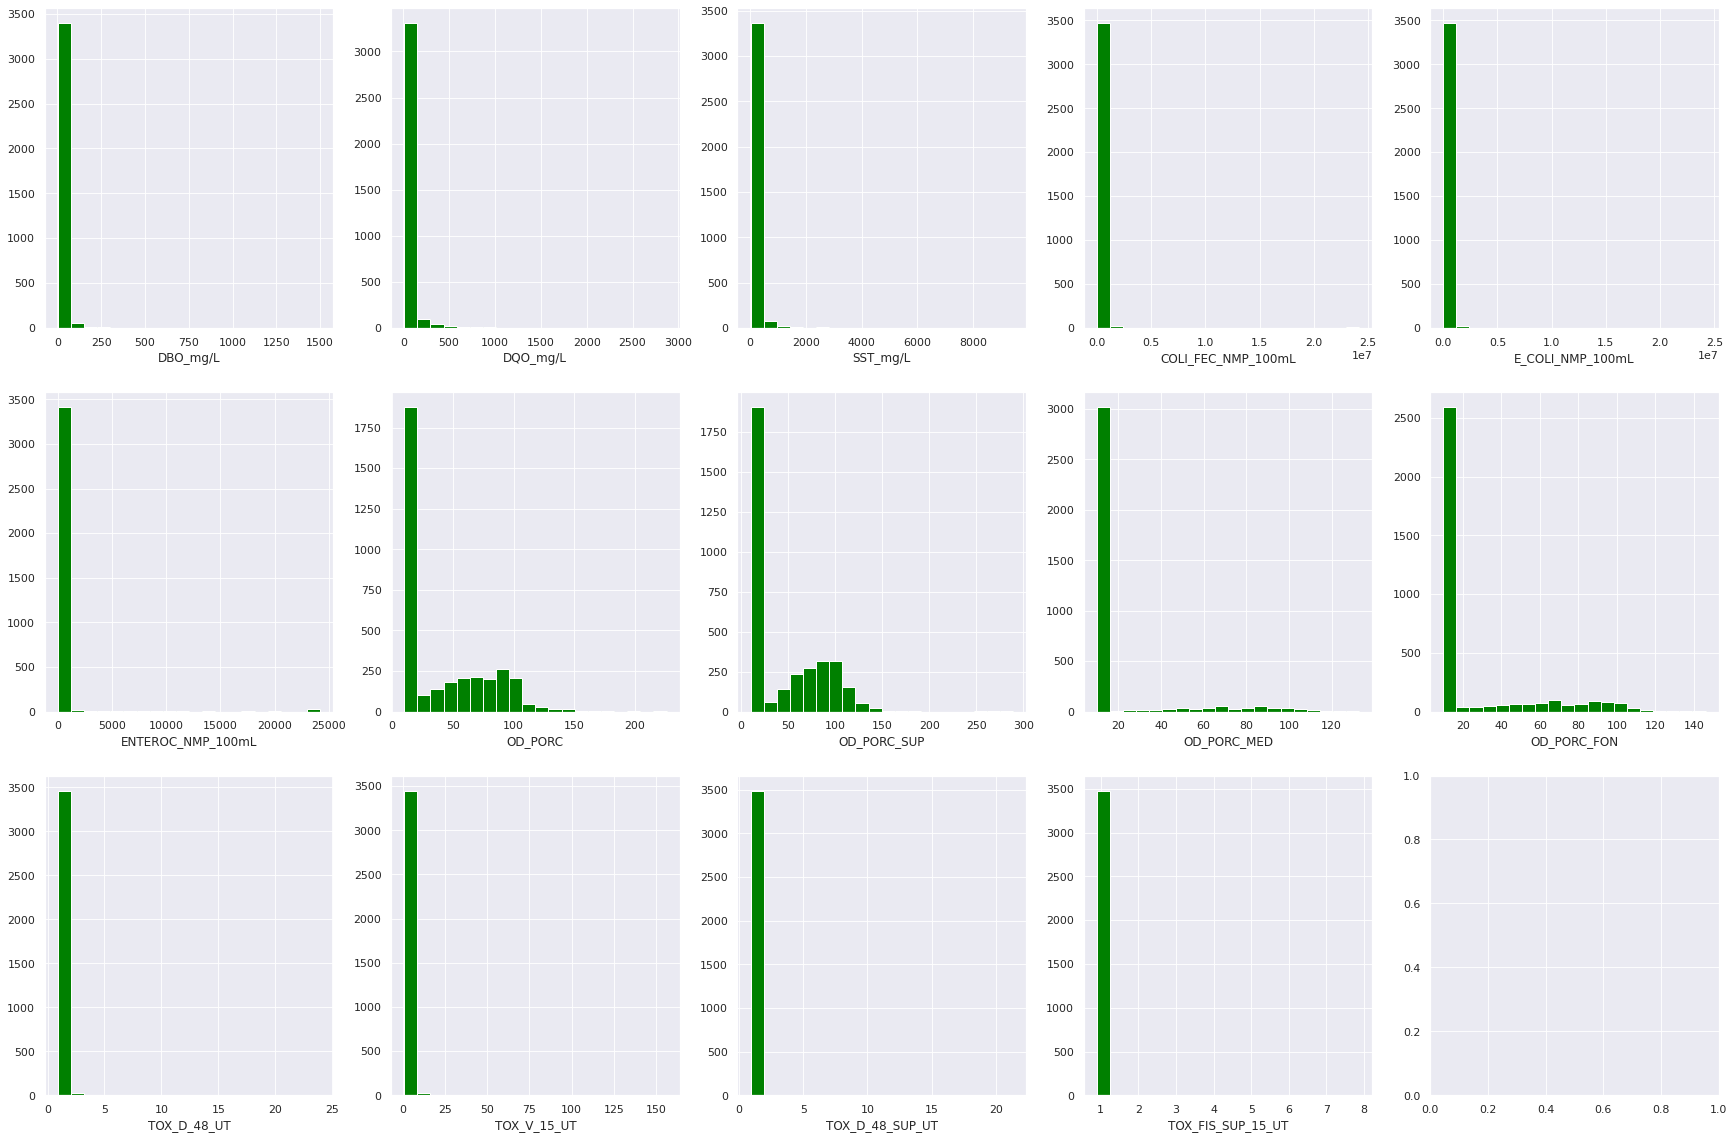

In [363]:
sns.set(rc={'figure.figsize':(30,20)})
fig, axes = plt.subplots(3, 5)
i = 0
for col in asup[num_nom_cal].columns:
  plt.subplot(3, 5,i+1) 
  plt.hist(asup[col], bins=20,color='green') 
  plt.xlabel(asup[num_nom_cal].columns[i])
  i = i + 1

Vemos que en los gráficos se muestra que las variables numéricas tienen en su mayoría un sesgo positivo.

### Ahora veamos las gráficas de **Boxplot** de cada una:

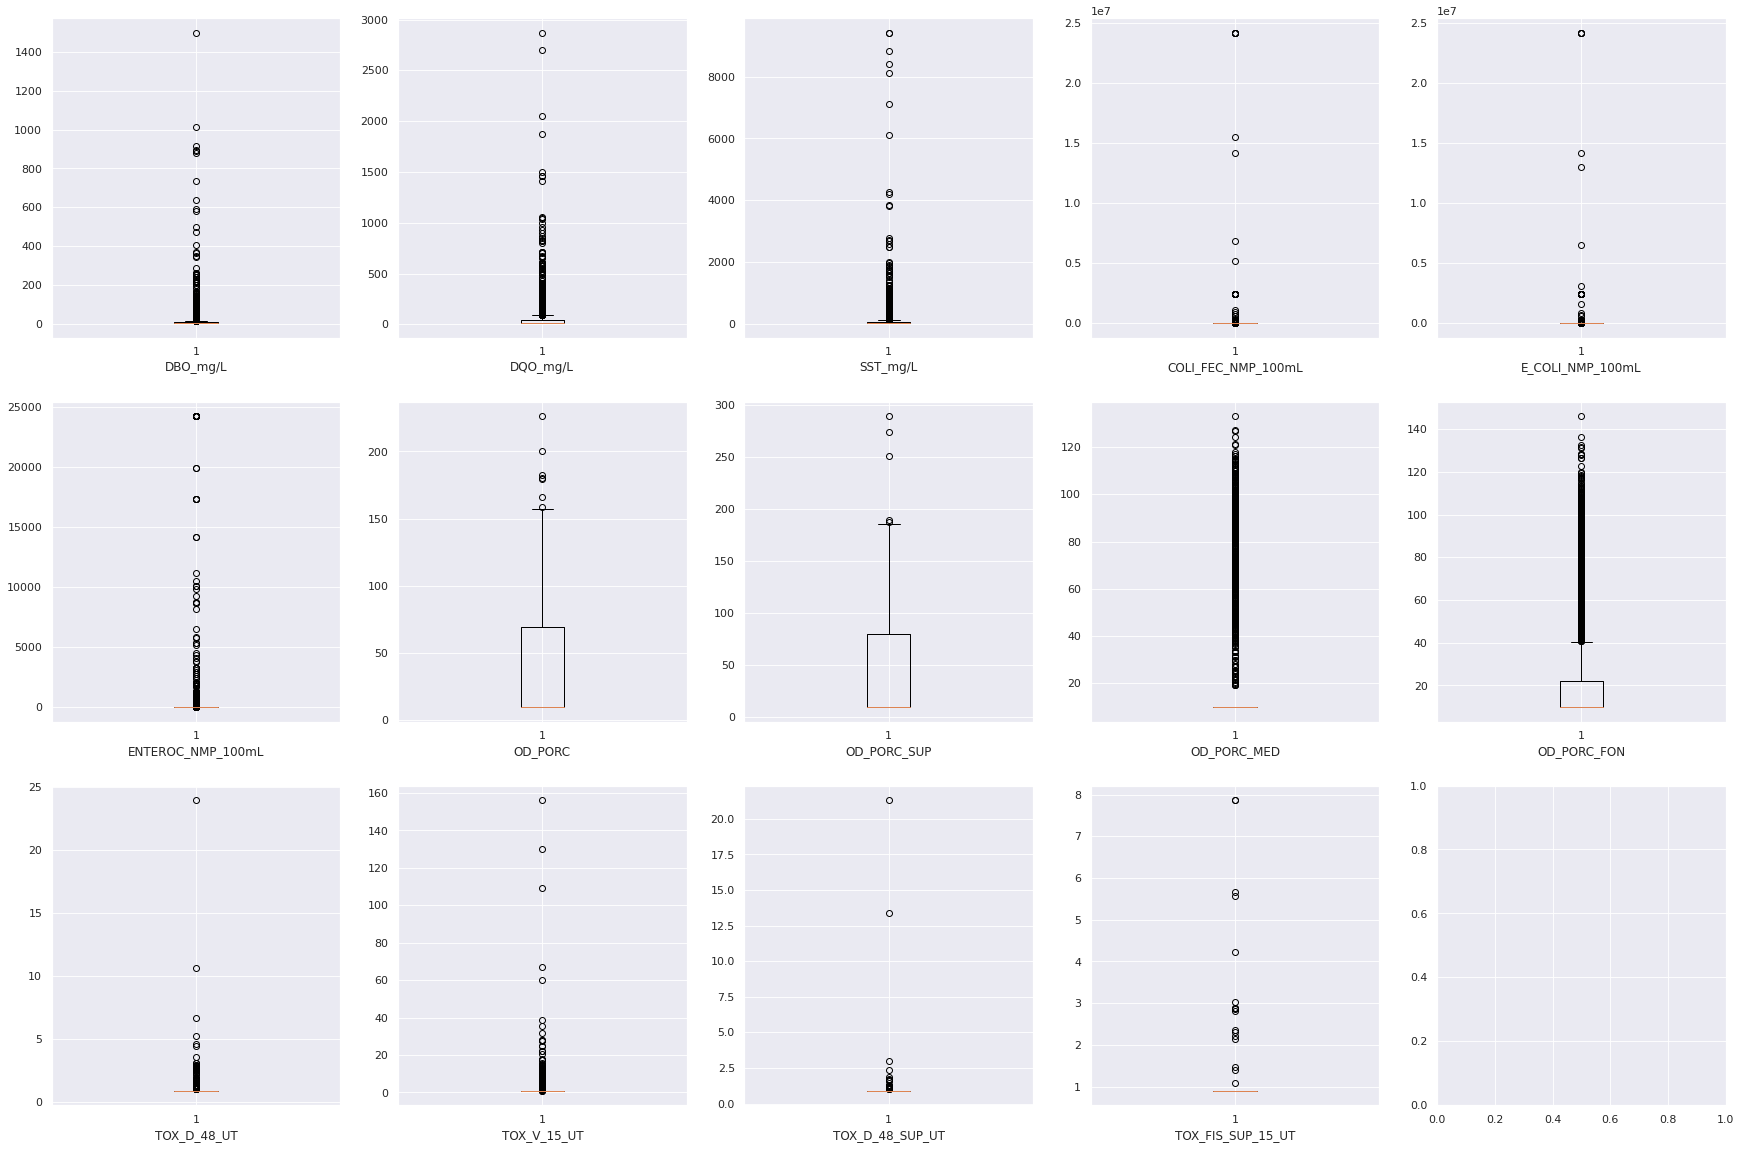

In [364]:
sns.set(rc={'figure.figsize':(30,20)})
fig, axes = plt.subplots(3, 5)
i = 0
for col in asup[num_nom_cal].columns:
  plt.subplot(3, 5,i+1) 
  plt.boxplot(asup[col]) 
  plt.xlabel(asup[num_nom_cal].columns[i])
  i = i + 1

Todas tienen valores extremos en general. Y observamos el sesgo que creamos al imputar tantos datos. Los promedios de muchos se encuentran en sus valores mínimos.

### Identificando tendencias centrales promedio, media, mediana, medidas de dispersión, máximo, mínimo.  

In [365]:
asup[num_nom_cal].describe(include='all')# aqui incluimos todos los registros de las variables numericas

,DBO_mg/L,DQO_mg/L,SST_mg/L,COLI_FEC_NMP_100mL,E_COLI_NMP_100mL,ENTEROC_NMP_100mL,OD_PORC,OD_PORC_SUP,OD_PORC_MED,OD_PORC_FON,TOX_D_48_UT,TOX_V_15_UT,TOX_D_48_SUP_UT,TOX_FIS_SUP_15_UT
count,3493.000000,3493.000000,3493.000000,3.493000e+03,3.493000e+03,3493.000000,3493.000000,3493.000000,3493.000000,3493.000000,3493.000000,3493.000000,3493.000000,3493.000000
mean,12.938565,50.104876,102.017313,7.073322e+04,5.864658e+04,283.380303,39.190209,43.067506,18.500658,25.327827,0.934528,1.318584,0.912608,0.912416
std,56.384078,130.991203,441.623537,1.005794e+06,9.045238e+05,2240.514545,36.303432,40.642054,23.527581,29.262550,0.478154,4.591021,0.408624,0.227127
min,1.900000,9.900000,9.900000,2.900000e+00,2.900000e+00,2.900000,9.900000,9.900000,9.900000,9.900000,0.900000,0.900000,0.900000,0.900000
25%,1.900000,9.900000,9.900000,2.900000e+00,2.900000e+00,2.900000,9.900000,9.900000,9.900000,9.900000,0.900000,0.900000,0.900000,0.900000
50%,1.900000,15.960000,24.300000,7.380000e+02,8.600000e+01,2.900000,9.900000,9.900000,9.900000,9.900000,0.900000,0.900000,0.900000,0.900000
75%,6.760000,42.620000,57.000000,1.100000e+04,2.400000e+03,2.900000,69.400000,80.300000,9.900000,22.200000,0.900000,0.900000,0.900000,0.900000
max,1500.000000,2871.250000,9430.000000,2.419600e+07,2.419600e+07,24196.000000,226.100000,289.000000,133.000000,146.000000,23.949000,156.250000,21.320000,7.870000


In [366]:
asup[num_nom_cal].median()#agregamos la mediana que no está includia en el metodo describe()

DBO_mg/L                1.90
DQO_mg/L               15.96
SST_mg/L               24.30
COLI_FEC_NMP_100mL    738.00
E_COLI_NMP_100mL       86.00
ENTEROC_NMP_100mL       2.90
OD_PORC                 9.90
OD_PORC_SUP             9.90
OD_PORC_MED             9.90
OD_PORC_FON             9.90
TOX_D_48_UT             0.90
TOX_V_15_UT             0.90
TOX_D_48_SUP_UT         0.90
TOX_FIS_SUP_15_UT       0.90
dtype: float64

Donde podemos observar que los máximos y mínimos de cada columna de calidad se encuentran en magnitudes muy diferentes. Por lo que podría en un futuro ayudar escalar los datos. Así mismo, al ver los boxplots y al comparar el valor del tercer cuartil contra su máximo valor en todas las variables de calidad, podemos ver que existen outliers. Observemos más a detalle:

### Identificar medidas de posición no centrales, los cuartiles, outliers. 

In [367]:
for col in asup[num_nom_cal].columns:
  outliers = find_outliers_IQR(asup[col])
  print('\033[1m' + col + '\033[0m')
  print('number of outliers:', '\033[1m' + str(len(outliers))+ '\033[0m', 'max outlier value:', '\033[1m'+ str(outliers.max()) + '\033[0m', 'min outlier value:','\033[1m' + str(outliers.min()) + '\033[0m')

DBO_mg/L
number of outliers: 499 max outlier value: 1500.0 min outlier value: 14.1
DQO_mg/L
number of outliers: 386 max outlier value: 2871.25 min outlier value: 92.03
SST_mg/L
number of outliers: 443 max outlier value: 9430.0 min outlier value: 127.88
COLI_FEC_NMP_100mL
number of outliers: 167 max outlier value: 24196000.0 min outlier value: 27550.0
E_COLI_NMP_100mL
number of outliers: 652 max outlier value: 24196000.0 min outlier value: 6131.0
ENTEROC_NMP_100mL
number of outliers: 440 max outlier value: 24196.0 min outlier value: 3.1
OD_PORC
number of outliers: 7 max outlier value: 226.1 min outlier value: 158.8
OD_PORC_SUP
number of outliers: 5 max outlier value: 289.0 min outlier value: 187.7
OD_PORC_MED
number of outliers: 473 max outlier value: 133.0 min outlier value: 19.1
OD_PORC_FON
number of outliers: 749 max outlier value: 146.0 min outlier value: 40.7
TOX_D_48_UT
number of outliers: 87 max outlier value: 23.949 min outlier value: 1.003
TOX_V_15_UT
number of outliers: 148 ma

### A continuación tenemos las graficas **Pairplot** de las variables numericas y sus relaciones entre ellas:

In [368]:
sns.set(style="ticks", color_codes=True)

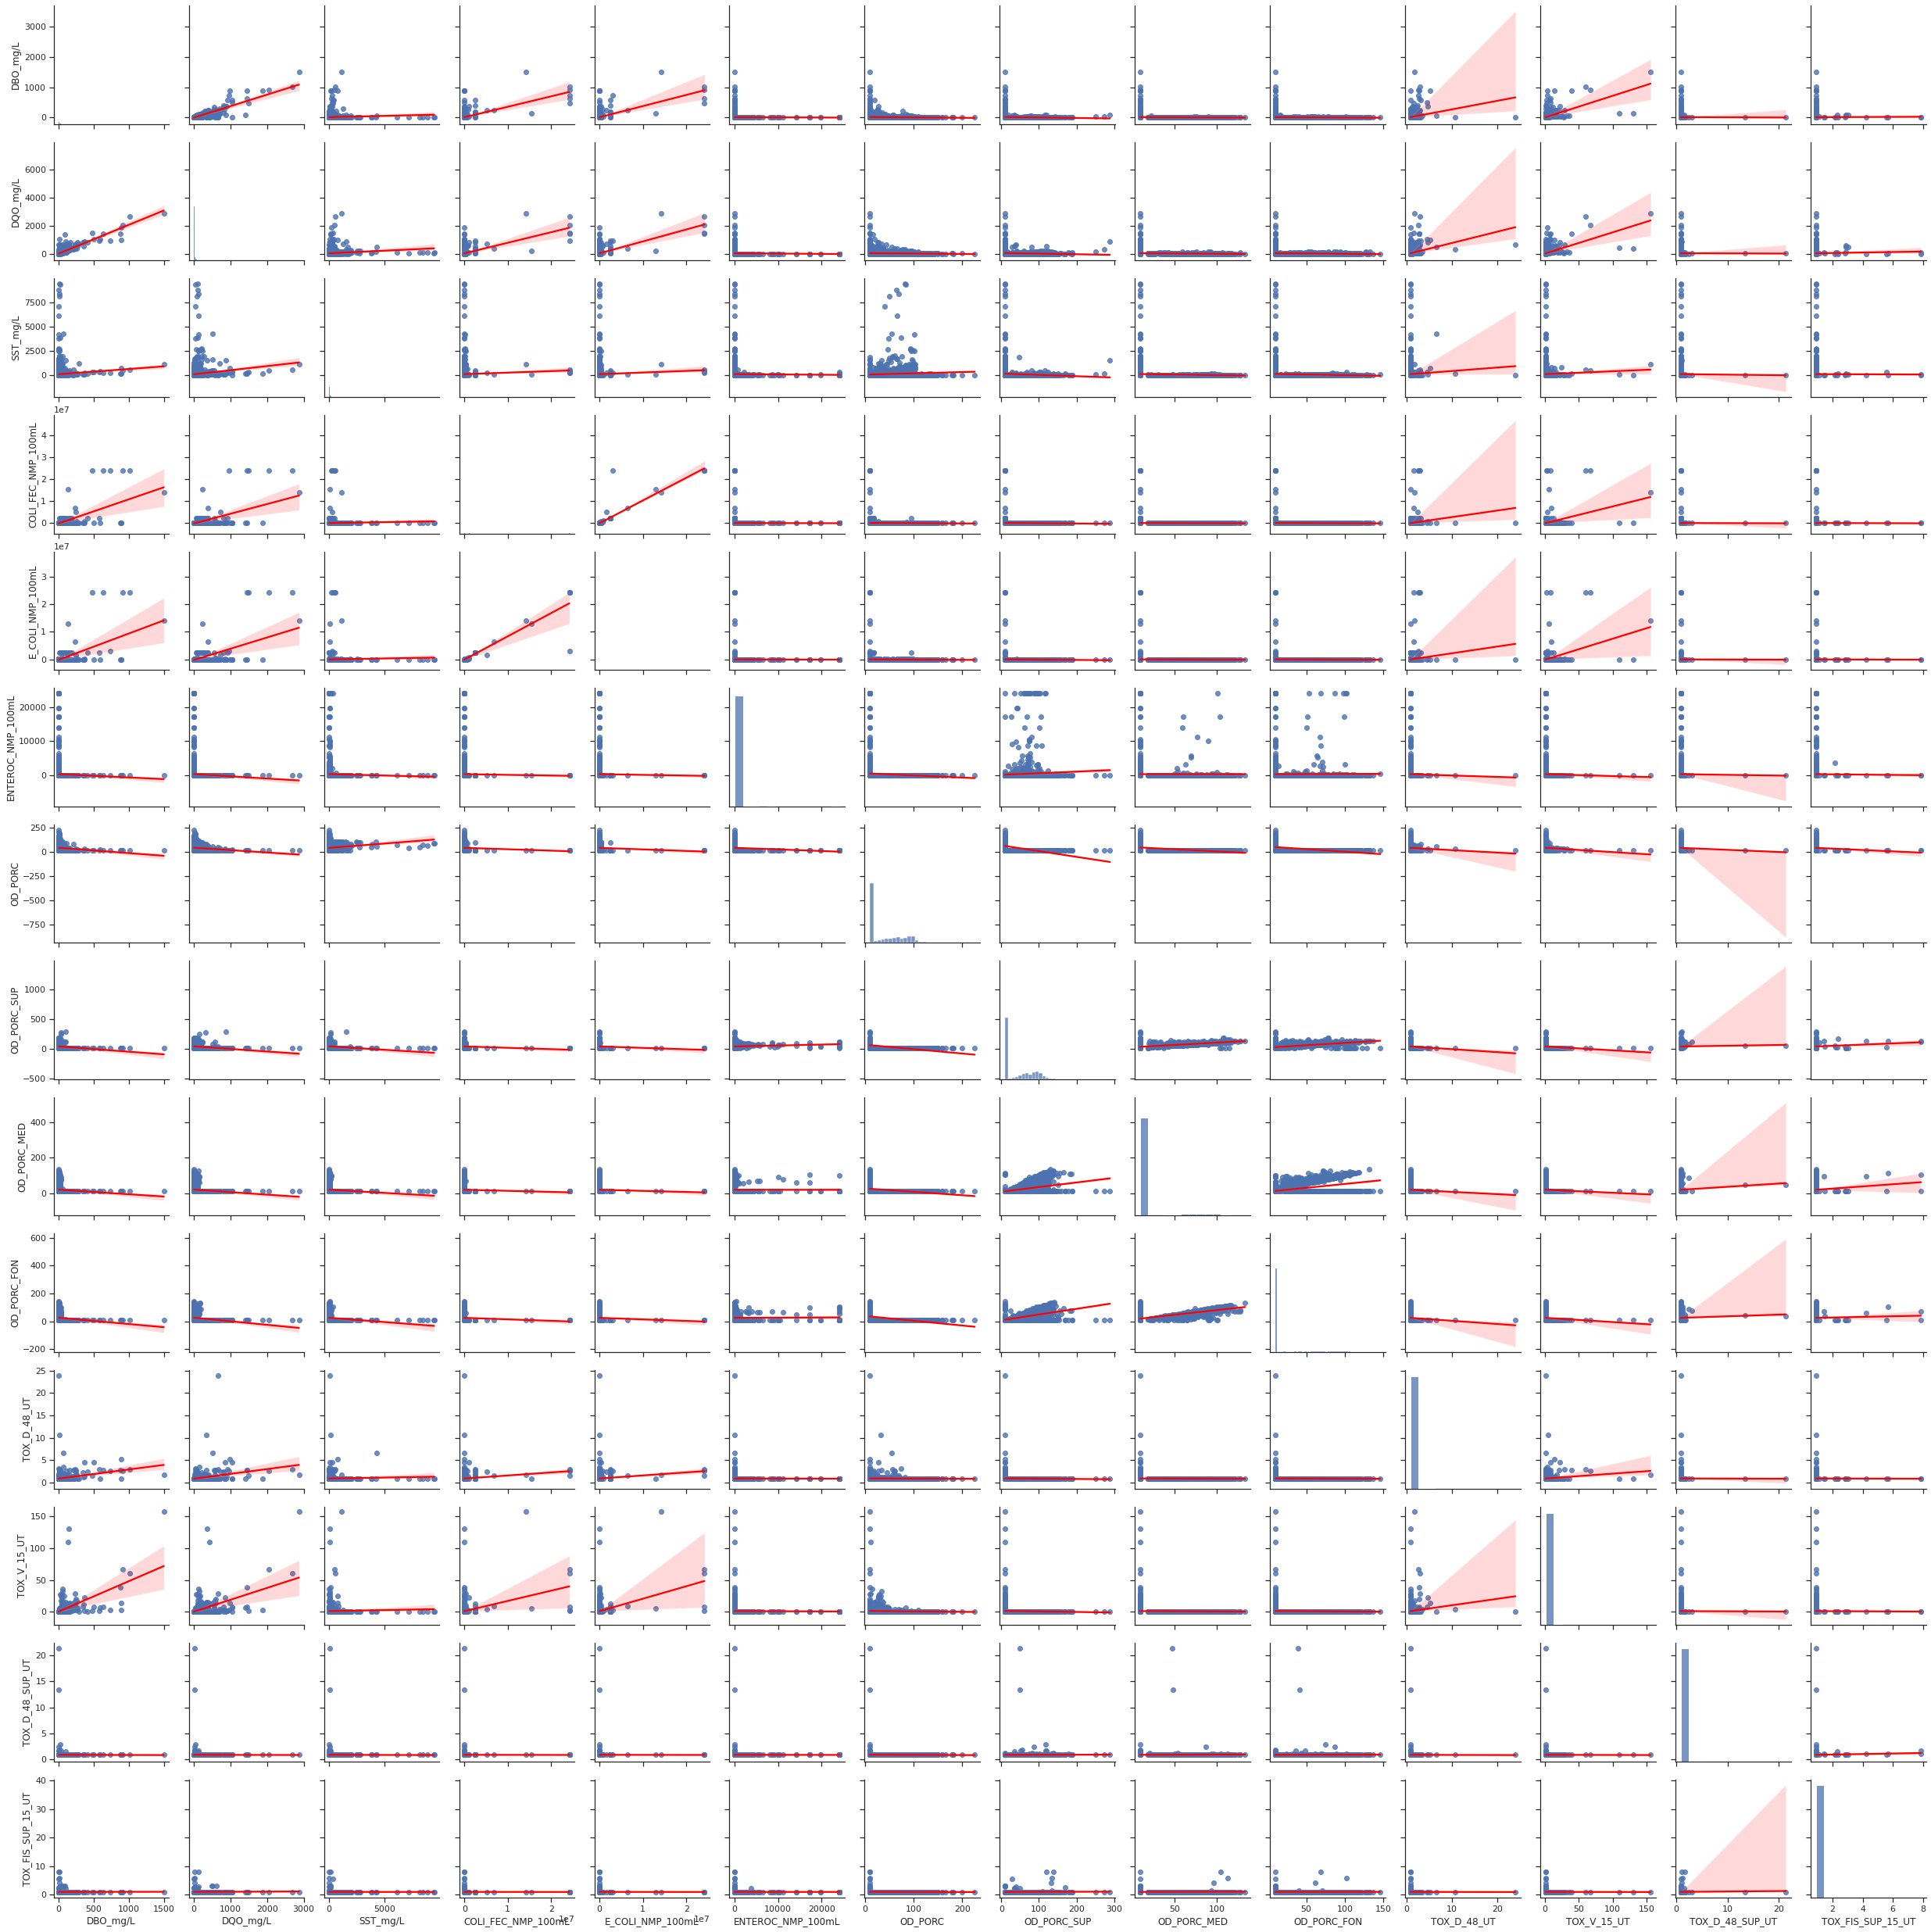

In [369]:
#grafico de pairplot de las numericas
sns.pairplot(asup[num_nom_cal], kind="reg", plot_kws={'line_kws':{'color':'red'}})

### Identificar correlaciones.

Veamos ahora el **mapa de correlación** de las numéricas:

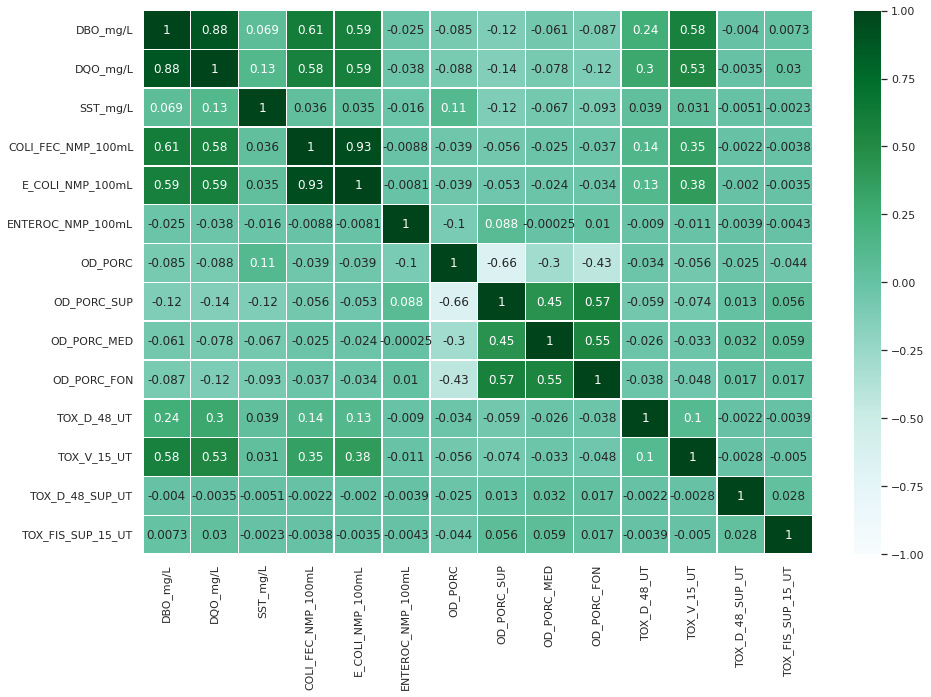

In [370]:
corr_num = asup[num_nom_cal].corr()

sns.set(rc = {'figure.figsize':(15,10)})
sns.heatmap(corr_num, vmin = -1, vmax = 1, cmap = "BuGn", annot= True, linewidths=0.5)

Donde obtenemos la máxima correlación de cada variable:

In [371]:
max_corr_list = list()
max_5_corr_list = list()
for col in corr_num.columns:
  max_corr = list()
  max = corr_num[col].abs().nlargest(2)[1]
  indx = corr_num[corr_num[col].abs()==max].index.values[0]
  max_corr.append(col);max_corr.append(corr_num[col][indx]);max_corr.append(indx)
  max_corr_list.append(max_corr)
  print(col + ':',corr_num[col][indx], 'con', indx)

DBO_mg/L: 0.884231169062571 con DQO_mg/L
DQO_mg/L: 0.884231169062571 con DBO_mg/L
SST_mg/L: 0.1269693343676913 con DQO_mg/L
COLI_FEC_NMP_100mL: 0.9321858450530641 con E_COLI_NMP_100mL
E_COLI_NMP_100mL: 0.9321858450530641 con COLI_FEC_NMP_100mL
ENTEROC_NMP_100mL: -0.10103078616483516 con OD_PORC
OD_PORC: -0.6586221133118895 con OD_PORC_SUP
OD_PORC_SUP: -0.6586221133118895 con OD_PORC
OD_PORC_MED: 0.54732245117932 con OD_PORC_FON
OD_PORC_FON: 0.5739051440974791 con OD_PORC_SUP
TOX_D_48_UT: 0.2951420541864647 con DQO_mg/L
TOX_V_15_UT: 0.5808477898943718 con DBO_mg/L
TOX_D_48_SUP_UT: 0.0320987964594418 con OD_PORC_MED
TOX_FIS_SUP_15_UT: 0.05906350144399502 con OD_PORC_MED


Obtenemos las 5 correlaciones más fuertes:

In [372]:
all_values = list()
for col in corr_num.columns:
  for indx in corr_num.index:
    if corr_num[col][indx] != 1:
      all_values.append(corr_num[col][indx])

for val in Nmaxelements(all_values,5):
  break_1 = False
  for col in corr_num.columns:
    for indx in corr_num.index:
      if corr_num[col][indx] == val:
        print(col,'con',indx,'con',val)
        break_1 = True
        break
    if break_1:
      break

COLI_FEC_NMP_100mL con E_COLI_NMP_100mL con 0.9321858450530641
DBO_mg/L con DQO_mg/L con 0.884231169062571
OD_PORC con OD_PORC_SUP con -0.6586221133118895
DBO_mg/L con COLI_FEC_NMP_100mL con 0.6148973013170023
DBO_mg/L con E_COLI_NMP_100mL con 0.5897501660887863


### Ahora veamos los **countplots** de las categorías:

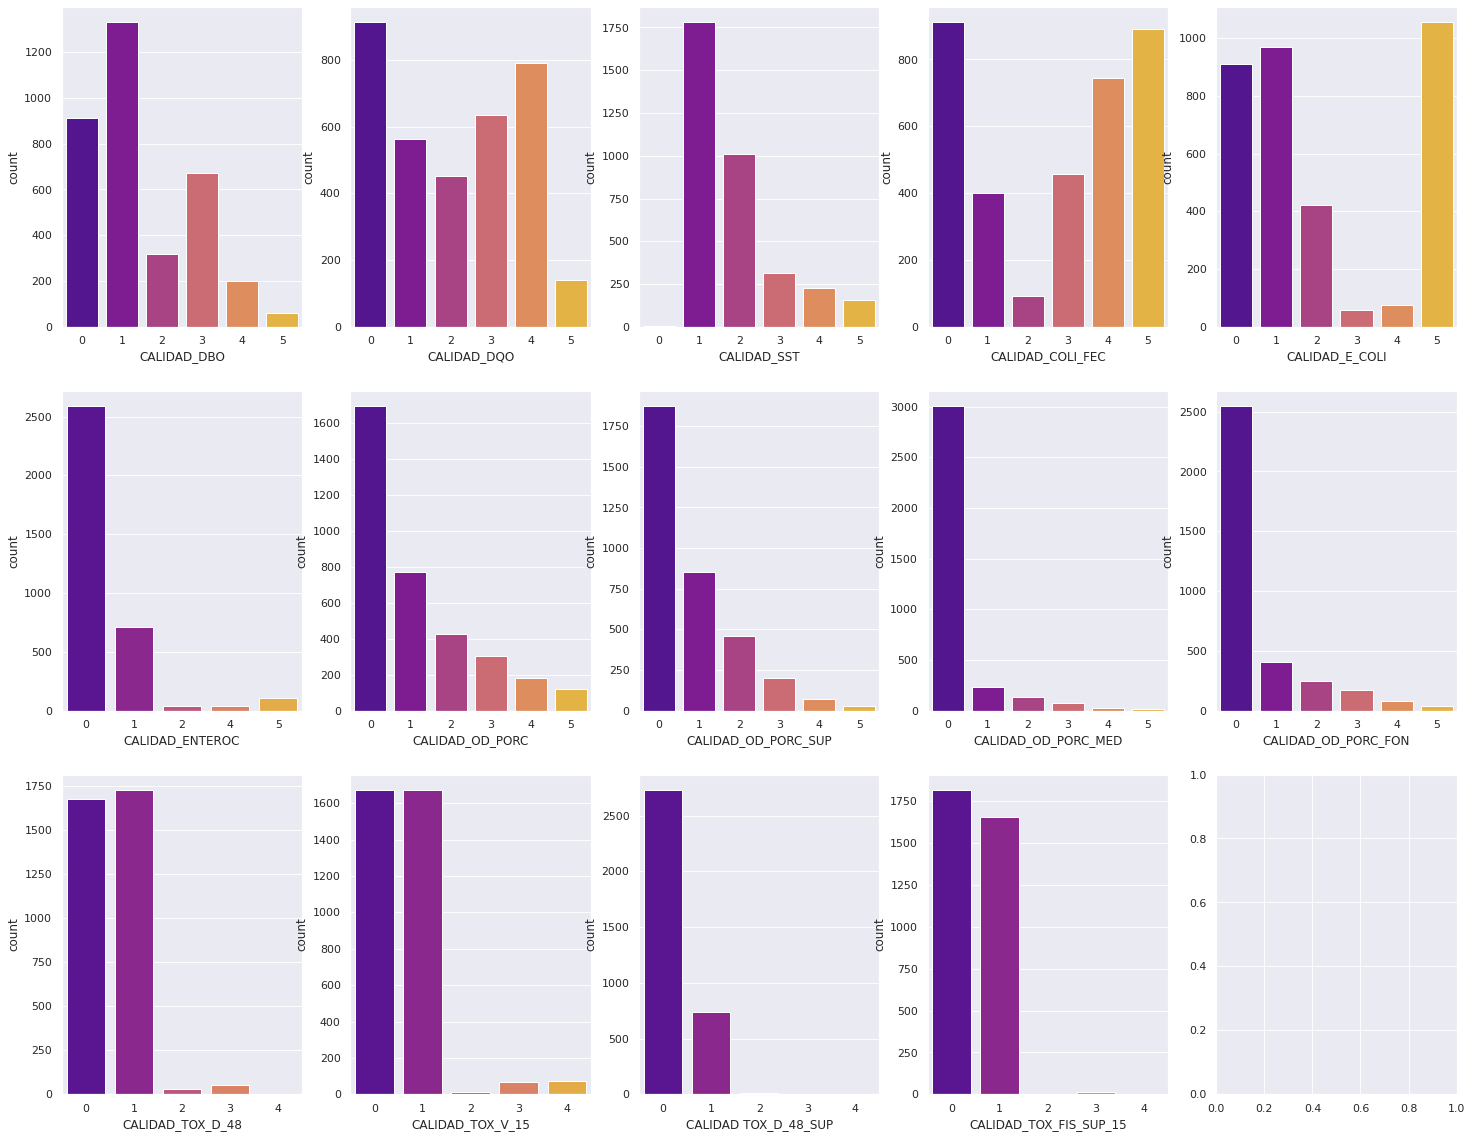

In [373]:
sns.set(rc={'figure.figsize':(25,20)})
fig, axes = plt.subplots(3, 5)
i = 0
for col in asup[cat_nom_cal].columns:
  plt.subplot(3, 5,i+1) 
  sns.countplot(x=asup[col],data=asup,palette='plasma')
  plt.xlabel(asup[cat_nom_cal].columns[i])
  i = i + 1

Vemos claramente los bines de cada variable ya codificados de manera Discreta con valores 1,2,3, etcétera cuando hicimos la limpieza y conversión

### Preparar los datos 

In [374]:
trans_asup = asup[['CLAVE'] + num_nom_geo + cat_nom + num_nom_cal + cat_nom_cal + y_nom].copy()

Buscamos que tipo de transformación logra normalizar más los datos:

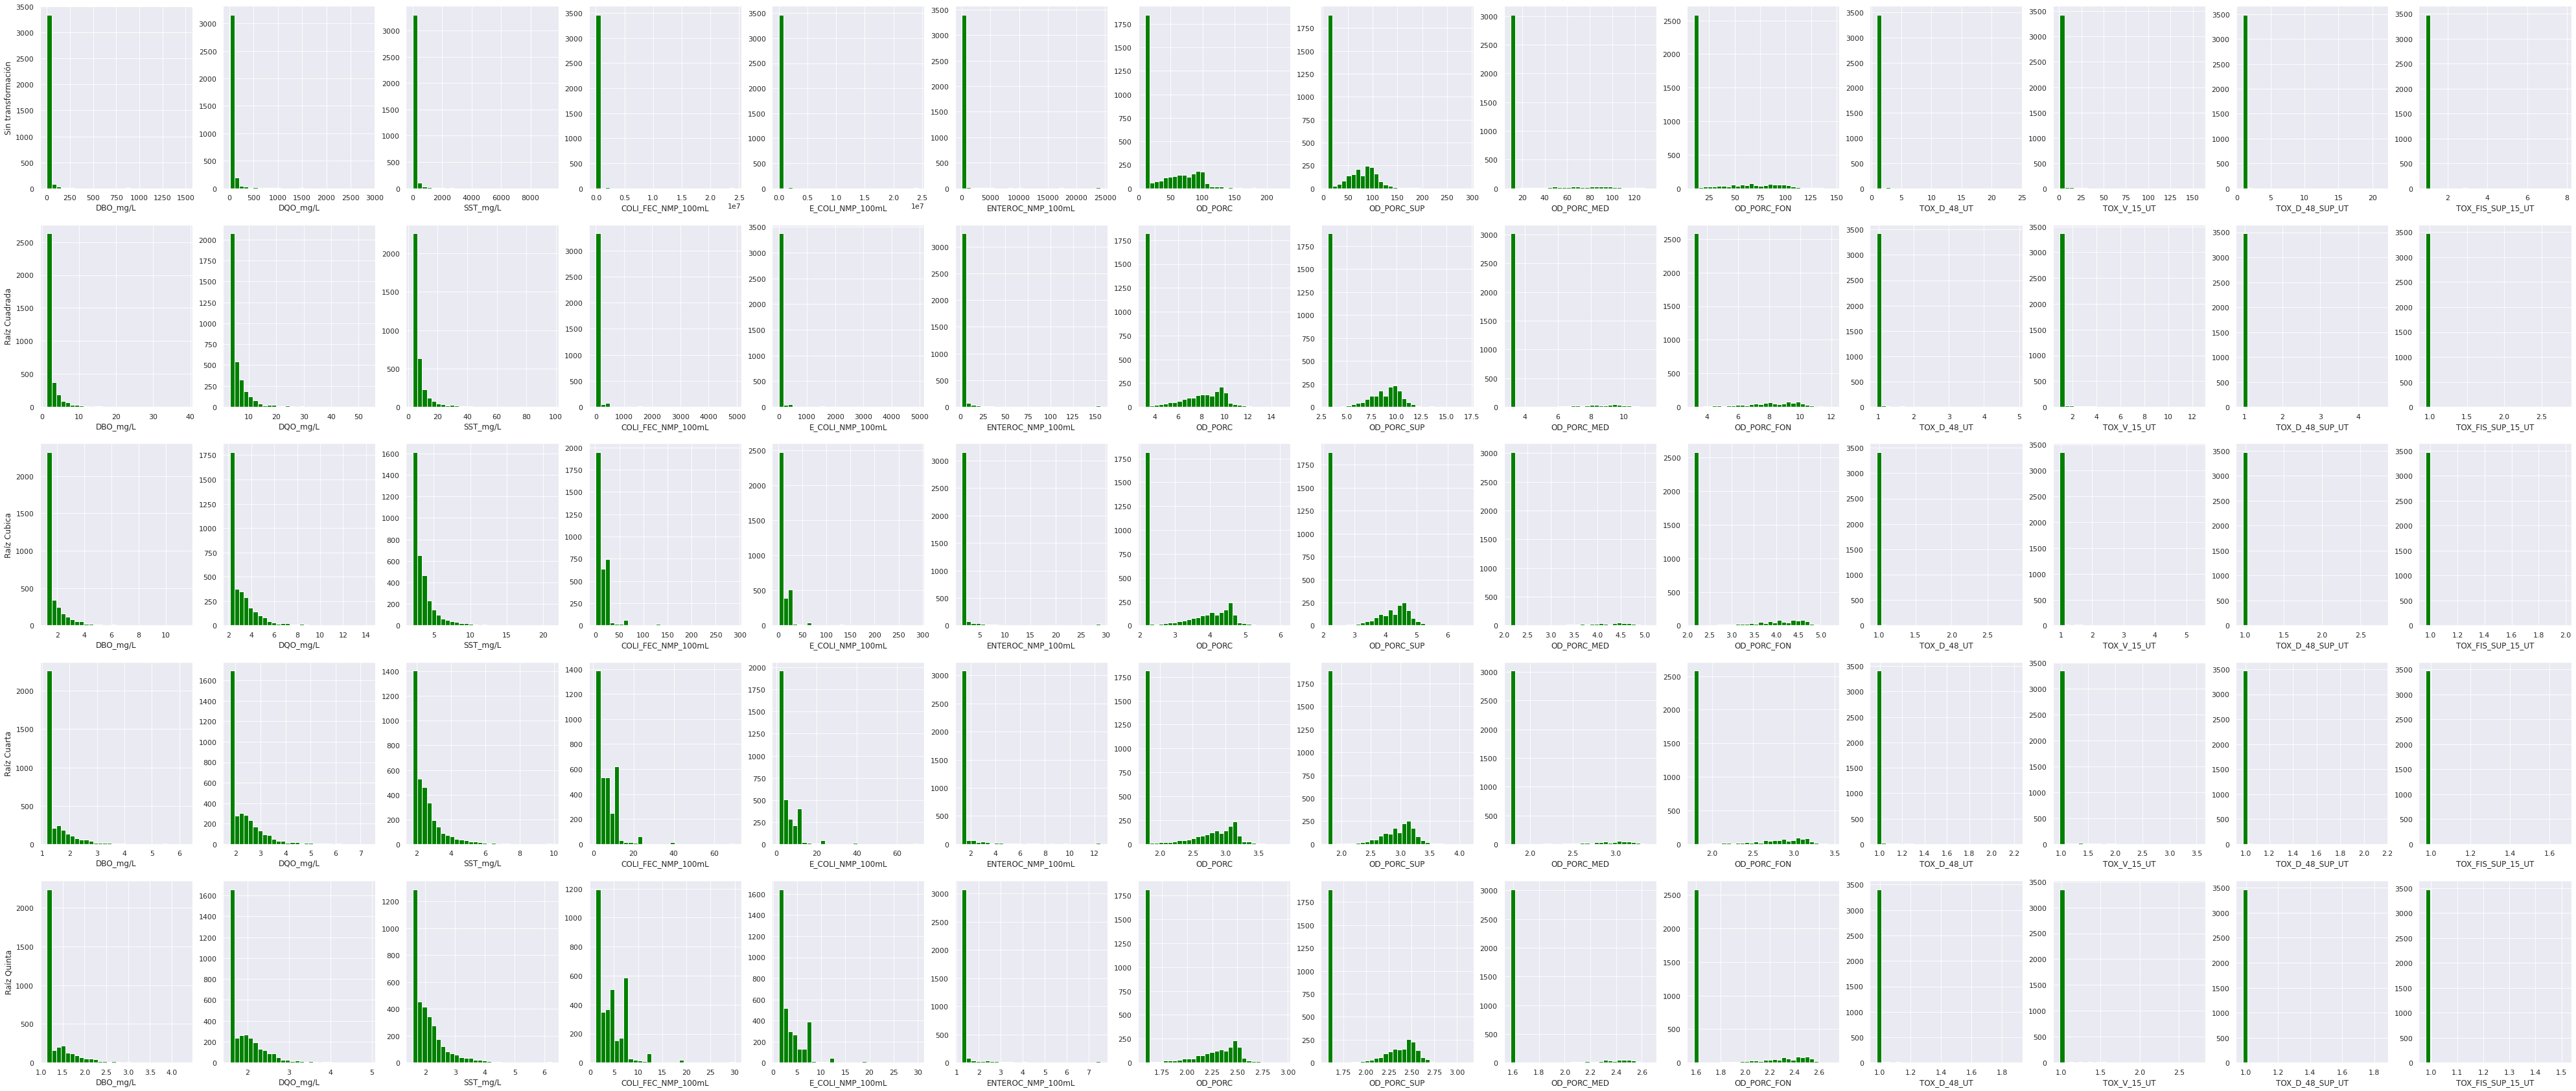

In [375]:
df_transform = trans_asup[num_nom_cal]
nvar = len(trans_asup[num_nom_cal].columns)
nplots = 5
sns.set(rc={'figure.figsize':(nvar*5,30)})
k=0
fig, axes = plt.subplots(nplots, nvar)   
for k in range(0,nvar):  
  plt.subplot(nplots, nvar,k+1) 

  Transf0 = trans_asup[num_nom_cal].iloc[:,k].to_numpy().reshape(-1, 1) 
  plt.hist(Transf0, bins=30,color='green') 
  plt.xlabel(df_transform.columns[k])
  if k==0:
    plt.ylabel('Sin transformación')
  
  plt.subplot(nplots, nvar,k+1+nvar*1)    
  Transf1 = np.sqrt(Transf0)       
  plt.hist(Transf1, bins=30,color='green')                      
  plt.xlabel(df_transform.columns[k])
  if k==0:
    plt.ylabel('Raíz Cuadrada')

  plt.subplot(nplots, nvar,k+1+nvar*2)  
  Transf2 = np.power(Transf0,1/3)    
  plt.hist(Transf2, bins=30,color='green')                   
  plt.xlabel(df_transform.columns[k])
  if k==0:
    plt.ylabel('Raíz Cubica')

  plt.subplot(nplots, nvar,k+1+nvar*3)    
  Transf3 = np.power(Transf0,1/4)        
  plt.hist(Transf3, bins=30,color='green')                   
  plt.xlabel(df_transform.columns[k])
  if k==0:
    plt.ylabel('Raíz Cuarta')  

  plt.subplot(nplots, nvar,k+1+nvar*4)  
  Transf4 = np.power(Transf0,1/5)     
  plt.hist(Transf4, bins=30,color='green')                   
  plt.xlabel(df_transform.columns[k])
  if k==0:
    plt.ylabel('Raíz Quinta')

Observamos que, aunque a más de la mitad no les hace efecto, la que mejor comportamiento tiene es la raíz cubica:

In [376]:
for col in trans_asup[num_nom_cal].columns:
  trans_asup[col] = pd.DataFrame(np.power(trans_asup[col],1/3), columns = [col])

In [377]:
trans_asup[num_nom_cal]

,DBO_mg/L,DQO_mg/L,SST_mg/L,COLI_FEC_NMP_100mL,E_COLI_NMP_100mL,ENTEROC_NMP_100mL,OD_PORC,OD_PORC_SUP,OD_PORC_MED,OD_PORC_FON,TOX_D_48_UT,TOX_V_15_UT,TOX_D_48_SUP_UT,TOX_FIS_SUP_15_UT
0,1.817121,3.781629,2.395710,10.513211,4.610436,1.426043,2.147229,3.603700,2.147229,2.147229,0.965489,0.965489,0.965489,0.965489
1,1.238562,2.147229,2.147229,1.426043,1.426043,2.714418,2.147229,4.514357,4.569298,4.517626,0.965489,0.965489,0.965489,0.965489
2,1.238562,2.147229,2.147229,1.426043,1.426043,1.426043,2.147229,4.514357,4.569298,4.517626,0.965489,0.965489,0.965489,0.965489
3,1.238562,2.147229,2.408230,1.426043,1.426043,1.426043,2.147229,2.147229,2.147229,4.425949,0.965489,0.965489,0.965489,0.965489
4,1.238562,2.147229,2.147229,1.426043,1.426043,3.107233,2.147229,4.582035,4.577267,4.570894,0.965489,0.965489,0.965489,0.965489
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3488,1.238562,2.147229,4.959676,13.388659,13.388659,1.426043,4.103546,2.147229,2.147229,2.147229,0.965489,0.965489,0.965489,0.965489
3489,3.393818,4.875317,3.779763,13.388659,1.587401,1.426043,2.147229,4.507805,2.147229,2.147229,0.965489,0.965489,0.965489,0.965489
3490,1.638643,4.441886,4.121285,6.214465,2.466212,1.426043,4.287216,2.147229,2.147229,2.147229,0.965489,0.965489,0.965489,0.965489
3491,1.238562,3.299480,3.825862,13.388659,2.223980,1.426043,4.239536,2.147229,2.147229,2.147229,0.965489,0.965489,0.965489,0.965489


Escalamos los datos numéricos:

In [378]:
scaled_features = MinMaxScaler((1,10)).fit_transform(asup[num_nom_cal].values)
num_scaled = pd.DataFrame(scaled_features, columns = num_nom_cal)

for col in num_nom_cal:
  trans_asup[col] = num_scaled[col]

trans_asup[num_nom_cal]

,DBO_mg/L,DQO_mg/L,SST_mg/L,COLI_FEC_NMP_100mL,E_COLI_NMP_100mL,ENTEROC_NMP_100mL,OD_PORC,OD_PORC_SUP,OD_PORC_MED,OD_PORC_FON,TOX_D_48_UT,TOX_V_15_UT,TOX_D_48_SUP_UT,TOX_FIS_SUP_15_UT
0,1.024631,1.138962,1.003678,1.000431,1.000035,1.000000,1.000000,2.189896,1.000000,1.000000,1.0,1.0,1.0,1.0
1,1.000000,1.000000,1.000000,1.000000,1.000000,1.006361,1.000000,3.647438,7.251015,6.442322,1.0,1.0,1.0,1.0
2,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.647438,7.251015,6.442322,1.0,1.0,1.0,1.0
3,1.000000,1.000000,1.003885,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,6.078619,1.0,1.0,1.0,1.0
4,1.000000,1.000000,1.000000,1.000000,1.000000,1.010081,1.000000,3.782874,7.287571,6.660544,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3488,1.000000,1.000000,1.107101,1.000892,1.000892,1.000000,3.464385,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.0
3489,1.223423,1.333346,1.042133,1.000892,1.000000,1.000000,1.000000,3.634540,1.000000,1.000000,1.0,1.0,1.0,1.0
3490,1.015019,1.244521,1.057420,1.000088,1.000005,1.000000,3.868178,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.0
3491,1.000000,1.081842,1.044044,1.000892,1.000003,1.000000,3.759944,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.0


Y finalmente tenemos nuestro dataframe transformado y con las variables que podemos utilizar para el análisis:


In [379]:
trans_asup

,CLAVE,LONGITUD,LATITUD,ORGANISMO_DE_CUENCA,SUBTIPO,GRUPO,DBO_mg/L,DQO_mg/L,SST_mg/L,COLI_FEC_NMP_100mL,...,CALIDAD_ENTEROC,CALIDAD_OD_PORC,CALIDAD_OD_PORC_SUP,CALIDAD_OD_PORC_MED,CALIDAD_OD_PORC_FON,CALIDAD_TOX_D_48,CALIDAD_TOX_V_15,CALIDAD TOX_D_48_SUP,CALIDAD_TOX_FIS_SUP_15,SEMAFORO
0,DLAGU8,-102.33911,22.24730,6.0,22.0,1.0,1.024631,1.138962,1.003678,1.000431,...,0,0,3,0,0,0,0,1,1,3
1,DLBAJ100,-109.84290,22.90473,10.0,21.0,0.0,1.000000,1.000000,1.000000,1.000000,...,1,0,1,1,1,0,0,0,1,1
2,DLBAJ101,-109.86442,22.89880,10.0,21.0,0.0,1.000000,1.000000,1.000000,1.000000,...,1,0,1,1,1,0,0,0,1,1
3,DLBAJ102,-109.88604,22.89609,10.0,2.0,0.0,1.000000,1.000000,1.003885,1.000000,...,1,0,0,0,1,0,0,0,1,1
4,DLBAJ103,-109.89657,22.87694,10.0,2.0,0.0,1.000000,1.000000,1.000000,1.000000,...,1,0,1,1,1,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3488,OCRBR5206M1,-99.42142,26.78971,12.0,24.0,2.0,1.000000,1.000000,1.107101,1.000892,...,0,2,0,0,0,1,1,0,0,2
3489,OCRBR5207M1,-99.53064,27.43714,12.0,14.0,1.0,1.223423,1.333346,1.042133,1.000892,...,0,0,1,0,0,0,0,1,1,3
3490,OCRBR5208M1,-99.50727,27.49901,12.0,24.0,2.0,1.015019,1.244521,1.057420,1.000088,...,0,1,0,0,0,1,1,0,0,3
3491,OCRBR5209M1,-99.52221,27.49631,12.0,24.0,2.0,1.000000,1.081842,1.044044,1.000892,...,0,1,0,0,0,1,1,0,0,2


## **Realizar análisis para encontrar si existe una relación entre la calidad del agua y su ubicación geográfica a través de K- means.**

Primero observamos la distribución de las clases en el semáforo:

Class=3, n=1091 (31.234%)
Class=1, n=1267 (36.273%)
Class=2, n=1135 (32.494%)


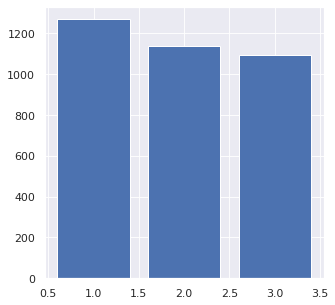

In [380]:
sns.set(rc={'figure.figsize':(5,5)})
y = trans_asup['SEMAFORO']
counter = Counter(y)
for k,v in counter.items():
	per = v / len(y) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
plt.bar(counter.keys(), counter.values())
plt.show()

Donde observamos que la clase mayoritaria es el semáforo color verde con 36.27%, seguido del amarillo con 32.49%, y finalmente el rojo con 31.23%

Ahora transformamos nuestra dataframe en una geo dataframe para trabajar con ella en base a longitud y latitud:

In [381]:
df_geo = trans_asup.copy()

df_geo["Coordinates"] = list(zip(df_geo.LONGITUD, df_geo.LATITUD))
df_geo["Coordinates"] = df_geo["Coordinates"].apply(Point)
df_geo.head()

,CLAVE,LONGITUD,LATITUD,ORGANISMO_DE_CUENCA,SUBTIPO,GRUPO,DBO_mg/L,DQO_mg/L,SST_mg/L,COLI_FEC_NMP_100mL,...,CALIDAD_OD_PORC,CALIDAD_OD_PORC_SUP,CALIDAD_OD_PORC_MED,CALIDAD_OD_PORC_FON,CALIDAD_TOX_D_48,CALIDAD_TOX_V_15,CALIDAD TOX_D_48_SUP,CALIDAD_TOX_FIS_SUP_15,SEMAFORO,Coordinates
0,DLAGU8,-102.33911,22.24730,6.0,22.0,1.0,1.024631,1.138962,1.003678,1.000431,...,0,3,0,0,0,0,1,1,3,POINT (-102.33911 22.2473)
1,DLBAJ100,-109.84290,22.90473,10.0,21.0,0.0,1.000000,1.000000,1.000000,1.000000,...,0,1,1,1,0,0,0,1,1,POINT (-109.8429 22.90473)
2,DLBAJ101,-109.86442,22.89880,10.0,21.0,0.0,1.000000,1.000000,1.000000,1.000000,...,0,1,1,1,0,0,0,1,1,POINT (-109.86442 22.8988)
3,DLBAJ102,-109.88604,22.89609,10.0,2.0,0.0,1.000000,1.000000,1.003885,1.000000,...,0,0,0,1,0,0,0,1,1,POINT (-109.88604 22.89609)
4,DLBAJ103,-109.89657,22.87694,10.0,2.0,0.0,1.000000,1.000000,1.000000,1.000000,...,0,1,1,1,0,0,0,1,1,POINT (-109.89657 22.87694)


In [382]:
gdf = gpd.GeoDataFrame(df_geo, geometry="Coordinates")


###La Inertia mide que tan bien un conjunto de datos esta siendo clusterizado por K-Means. Se calcula midiendo las distancias entre cada punto a su centroide y sacando el cuadrado de su distancia y sumando los cuadrados de dichas distancias de todos los puntos en ese cluster.

###Un buen modelo es aquel cuya INERTIA es baja y hay un numero bajo de clusters K, sin embargo es una situacion que hay que decidir ya que a medida que K se incrementa (clusters) la inertia decrece.

###Para encontrar el punto optimo de K para el dataset, utilizamos el metodo de ELBOW (Metodo de Codo) , para encontrar el punto donde el decremento en la INERTIA empieza a ser muy lento.

###Primeramente vamos a entrenar el modelo KMeans para una cantidad diferente de clusters y guardar el valor de Inertia de cada modelo entrenado. Y dibujamos la curva para encontrar el numero optimo de clusters.

Text(0.5, 1.0, 'Diferentes Valores de Inertia para los Diferentes números de Clusters')

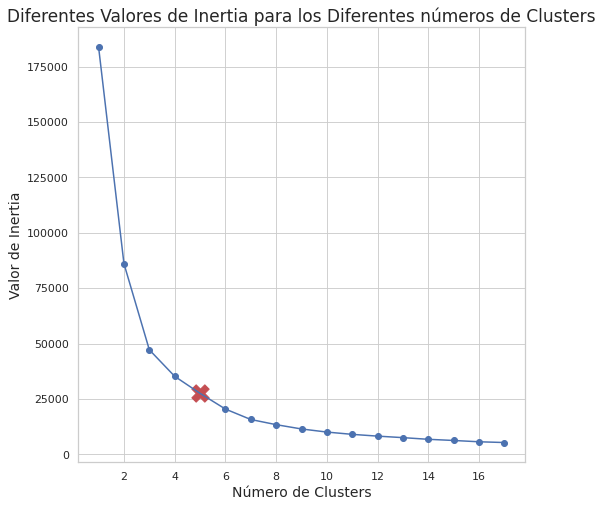

In [383]:
X = list(zip(gdf.LONGITUD, gdf.LATITUD))
MaxClusters = 18
# es una cantidad arbitraria que pusimos solo para para graficar

plt.rcParams['figure.figsize'] = [8,8]
sns.set_style("whitegrid")
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

inertia_list = []
for num_clusters in range(1, MaxClusters):
    kmeans_model = KMeans(n_clusters=num_clusters, init="k-means++")
    kmeans_model.fit(X)
    inertia_list.append(kmeans_model.inertia_)
    
# dibujamos la curva de inertia
plt.plot(range(1,MaxClusters),inertia_list)
plt.scatter(range(1,MaxClusters),inertia_list)
plt.scatter(5, inertia_list[4], marker="X", s=300, c="r")
plt.xlabel("Número de Clusters", size=14)
plt.ylabel("Valor de Inertia", size=14)
plt.title("Diferentes Valores de Inertia para los Diferentes números de Clusters", size=17)

Donde podemos ver que a en base a la métrica de inertia, 5 clusters es la cantidad de almacenes ideales. Sin embargo, queremos descubrir si con KMeans podemos encontrar agrupaciones geográficas donde de acuerdo a la calidad del agua.

In [384]:
kmeans = KMeans(n_clusters=5)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)
centers = kmeans.cluster_centers_

In [385]:
#sns.set(rc={'figure.figsize':(5,5)})
for c in range(0,len(np.bincount(y_kmeans))):
  indices = list()
  indices = [i for i, x in enumerate(y_kmeans) if x == c]
  counter = Counter(df_geo['SEMAFORO'][indices])
  print('\033[1m' + 'Cluster ' + str(c) + '\033[0m')
  for k,v in counter.items():
    per = v / len(indices) * 100
    print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
  #plt.bar(counter.keys(), counter.values())
  #plt.show()

Cluster 0
Class=1, n=274 (56.729%)
Class=3, n=87 (18.012%)
Class=2, n=122 (25.259%)
Cluster 1
Class=3, n=491 (46.017%)
Class=2, n=345 (32.334%)
Class=1, n=231 (21.649%)
Cluster 2
Class=3, n=338 (38.409%)
Class=1, n=231 (26.250%)
Class=2, n=311 (35.341%)
Cluster 3
Class=1, n=395 (59.220%)
Class=2, n=172 (25.787%)
Class=3, n=100 (14.993%)
Cluster 4
Class=2, n=185 (46.717%)
Class=1, n=136 (34.343%)
Class=3, n=75 (18.939%)


Donde observamos los porcentajes de cada clase para cada cluster. Y podemos ver que el mayor porcentaje en dos clusters son casi 60%. Sin embargo, no es un numero particularmente alto como para indicar si existe una relación de clases en base a ubicación geográfica. Especialmente porque los otros 3 clusters no tienen una diferencia grande entre porcentajes de clases.

Iteremos ahora obteniendo el promedio de porcentaje de la clase máxima para cada cluster, para confirmar si existe o no una relación entre zona geográfica y clases:

In [386]:
N_max = 80

max_class = list()

for N in range(1,N_max):
  kmeans = KMeans(n_clusters=N)
  kmeans.fit(X)
  y_kmeans = kmeans.predict(X)
  avg_list1 = list()
  for c in range(0,len(np.bincount(y_kmeans))):
    indices = list()
    indices = [i for i, x in enumerate(y_kmeans) if x == c]
    counter = Counter(df_geo['SEMAFORO'][indices])
    avg_list2 = list()
    for k,v in counter.items():
      per = v / len(indices) * 100
      avg_list2.append(per)
    avg_list1.append(np.max(avg_list2))
  centers = kmeans.cluster_centers_
  max_class.append([N,sum(avg_list1) / len(avg_list1)])

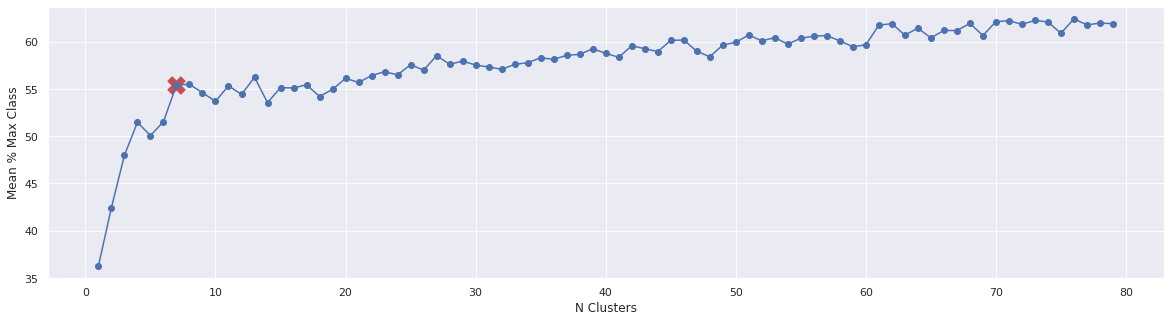

In [387]:
sns.set(rc={'figure.figsize':(20,5)})
plt.plot(pd.DataFrame(max_class)[0], pd.DataFrame(max_class)[1], '-o')
plt.scatter(7, pd.DataFrame(max_class)[1][6], marker="X", s=300, c="r")
plt.xlabel('N Clusters')
plt.ylabel('Mean % Max Class')

plt.show()

Donde observamos que la tendencia es que entre mayor número de clases, mayor porcentaje alcanza la clase máxima para cada cluster. Sin embargo, no por mucho. Tiene sentido ya que, si pusiéramos un cluster alado de cada toma de agua, pues el porcentaje de la clase mayoritaria serian 100%, ya que solo existiria una valor de una clase por cluster.

Observamos su comportamiento con 7 clusters, que es el último punto donde el promedio del porcentaje de la clase mayoritaria tiene un incremento considerable:

In [388]:
kmeans = KMeans(n_clusters=7)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)
centers = kmeans.cluster_centers_

In [389]:
#sns.set(rc={'figure.figsize':(5,5)})
for c in range(0,len(np.bincount(y_kmeans))):
  indices = list()
  indices = [i for i, x in enumerate(y_kmeans) if x == c]
  counter = Counter(df_geo['SEMAFORO'][indices])
  print('\033[1m' + 'Cluster ' + str(c) + '\033[0m')
  for k,v in counter.items():
    per = v / len(indices) * 100
    print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
  #plt.bar(counter.keys(), counter.values())
  #plt.show()

Cluster 0
Class=3, n=476 (47.316%)
Class=2, n=326 (32.406%)
Class=1, n=204 (20.278%)
Cluster 1
Class=1, n=86 (65.649%)
Class=3, n=41 (31.298%)
Class=2, n=4 (3.053%)
Cluster 2
Class=1, n=203 (50.248%)
Class=3, n=57 (14.109%)
Class=2, n=144 (35.644%)
Cluster 3
Class=2, n=188 (33.333%)
Class=1, n=277 (49.113%)
Class=3, n=99 (17.553%)
Cluster 4
Class=3, n=328 (39.661%)
Class=1, n=216 (26.119%)
Class=2, n=283 (34.220%)
Cluster 5
Class=1, n=148 (88.623%)
Class=2, n=4 (2.395%)
Class=3, n=15 (8.982%)
Cluster 6
Class=2, n=186 (47.208%)
Class=1, n=133 (33.756%)
Class=3, n=75 (19.036%)


Observamos que un cluster llega a cercano a 90% de la clase de semaforo verde. Lo que indica que este cluster si se puede identificar con un gran porcentaje de una clase. Pero ningun otro cluster tiene un commportamiento similar. No parece haber, exceptuando ese cluster indincado, una relacion significativa entre el valor del semaforo y la ubicacion geografica.

## **Mostrar resultados de agrupamiento de latitudes y longitudes con K means en el mapa de México.**

Concluyendo en el punto anterior, volvemos al máximo de 7 clusters para observar que esta sucediendo:

In [390]:
kmeans = KMeans(n_clusters=7)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)
centers = kmeans.cluster_centers_

In [391]:
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
world = world.set_index("iso_a3")

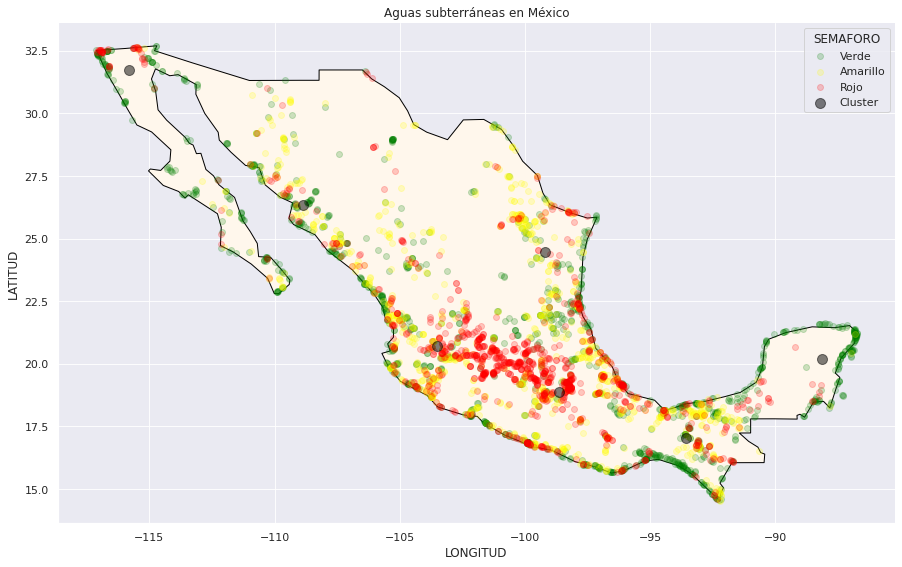

In [392]:
fig, gax = plt.subplots(figsize=(15,15))

world.query("name == 'Mexico'").plot(ax = gax, edgecolor='black', cmap='OrRd')

gdf.loc[gdf['SEMAFORO'] == 1].plot(ax=gax, color='green', alpha = 0.2, label='Verde')
gdf.loc[gdf['SEMAFORO'] == 2].plot(ax=gax, color='yellow', alpha = 0.2, label='Amarillo')
gdf.loc[gdf['SEMAFORO'] == 3].plot(ax=gax, color='red', alpha = 0.2, label='Rojo')
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=100, alpha=0.5, label='Cluster')
gax.legend(title = 'SEMAFORO')

gax.set_xlabel('LONGITUD')
gax.set_ylabel('LATITUD')
gax.set_title('Aguas subterráneas en México')

gax.spines['top'].set_visible(False)
gax.spines['right'].set_visible(False)

plt.show()

Donde podemos observar que para el área de la península de Yucatán si existe la tendencia a que el semáforo sea verde. Sin embargo, para todas las demás zonas no se puede observar alguna relación significativa entre la ubicación geográfica y el semáforo de calidad del agua. Y dado que estamos analizando para todo México, entonces no podemos llegar a una conclusión de zona geográfica con calidad del agua.